In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
from itertools import product

# Initial Setup

In [2]:
# Load data
df = pd.read_csv('titik_semprotan.csv')
ids = df['id'].tolist()
locations = df[['x', 'y']].values

# --- 0) Caching jarak antar titik (tetap boleh dipakai on-demand) ---
distance_cache = {}

# id -> index ke array locations (diasumsikan locations selaras dengan ids)
id2idx = {i: k for k, i in enumerate(ids)}

def get_weight(i, j):
    key = (i, j)
    if key in distance_cache:
        return distance_cache[key]
    ii, jj = id2idx[i], id2idx[j]
    dx = locations[ii][0] - locations[jj][0]
    dy = locations[ii][1] - locations[jj][1]
    d = float(np.hypot(dx, dy))
    distance_cache[(i, j)] = d
    distance_cache[(j, i)] = d
    return d

# --- 1) Nodes deterministik (order-preserving unique), bukan set(ids) ---
nodes = list(dict.fromkeys(ids))     # menjaga urutan, menghilangkan duplikat
N = len(nodes)

# mapping ID -> index baris/kolom di D
idx = {node: k for k, node in enumerate(nodes)}

# --- 2) Bangun matrix koordinat sesuai urutan nodes ---
coords = np.empty((N, 2), dtype=np.float64)
for k, node in enumerate(nodes):
    ii = id2idx[node]
    coords[k, 0] = locations[ii][0]
    coords[k, 1] = locations[ii][1]

# --- 3) Vectorized distance matrix (cepat & konsisten) ---
diff = coords[:, None, :] - coords[None, :, :]     # shape (N, N, 2)
D = np.sqrt((diff * diff).sum(axis=2))              # shape (N, N), float64
np.fill_diagonal(D, 0.0)                            # diagonal nol

# Opsional: pakai matrix D + idx (lebih cepat, no cache lookup)
def total_distance(tour):
    L = len(tour)
    if L < 2:
        return 0.0
    s = 0.0
    for i in range(L - 1):
        s += D[idx[tour[i]], idx[tour[i+1]]]
    s += D[idx[tour[-1]], idx[tour[0]]]
    return float(s)

def split_ids(ids, num_vehicles):
    ids_copy = ids[:]
    random.shuffle(ids_copy)
    return [ids_copy[i::num_vehicles] for i in range(num_vehicles)]

# K Clustering

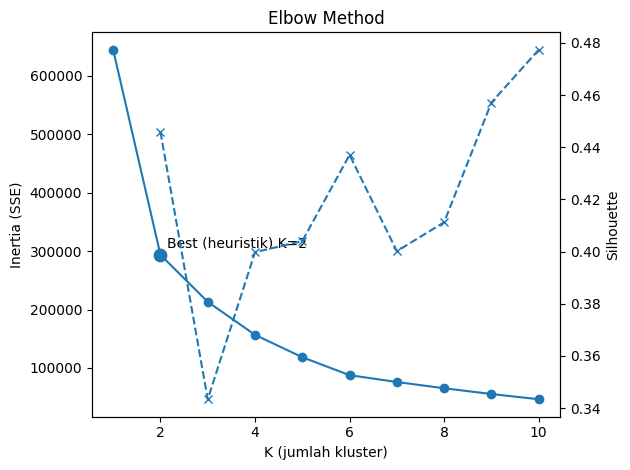

K kandidat: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Heuristik best K: 2
Jumlah kluster: 2
Cluster 0: 75 titik
Cluster 1: 60 titik


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow_analysis(coords, k_min=1, k_max=10, random_state=42, n_init=10, show_plot=True):
    k_values = list(range(k_min, min(k_max, len(coords)) + 1))
    inertias = []
    silhouettes = []

    for k in k_values:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        km.fit(coords)
        inertias.append(km.inertia_)
        if k >= 2:
            sil = silhouette_score(coords, km.labels_)
            silhouettes.append(sil)
        else:
            silhouettes.append(np.nan)

    # Heuristik "knee" sederhana: cari K yang memaksimalkan penurunan relatif inertia
    # (bukan metode resmi kneedle, tapi praktis untuk start)
    best_k = k_values[0]
    if len(k_values) >= 3:
        drops = []
        for i in range(1, len(inertias)):
            drop = (inertias[i-1] - inertias[i]) / max(inertias[i-1], 1e-9)
            drops.append(drop)
        # Pilih K setelah penurunan terbesar (i index drop untuk transisi k_values[i-1] -> k_values[i])
        best_k = k_values[np.argmax(drops) + 1]

    if show_plot:
        fig, ax1 = plt.subplots()
        ax1.plot(k_values, inertias, marker='o')
        ax1.set_xlabel('K (jumlah kluster)')
        ax1.set_ylabel('Inertia (SSE)')
        ax1.set_title('Elbow Method')
        # Tandai best_k jika masuk dalam range
        if best_k in k_values:
            ybk = inertias[k_values.index(best_k)]
            ax1.scatter([best_k], [ybk], s=80)
            ax1.annotate(f'Best (heuristik) K={best_k}', (best_k, ybk), xytext=(5, 5), textcoords='offset points')

        # Plot silhouette di sumbu kedua (opsional)
        ax2 = ax1.twinx()
        ax2.plot(k_values, silhouettes, marker='x', linestyle='--')
        ax2.set_ylabel('Silhouette')

        plt.tight_layout()
        plt.show()

    return {
        "k_values": k_values,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k_heuristic": best_k
    }

def run_kmeans(coords, nodes, k, random_state=42, n_init=10):
    if k < 1 or k > len(coords):
        raise ValueError("k harus di antara 1 dan jumlah titik.")
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(coords)
    centroids = km.cluster_centers_

    clusters = {c: [] for c in range(k)}
    for node, lab in zip(nodes, labels):
        clusters[int(lab)].append(node)

    return labels, clusters, centroids

# === Contoh pemakaian cepat ===
# 1) Cari K yang masuk akal
info = elbow_analysis(coords, k_min=1, k_max=10, random_state=0, n_init=20, show_plot=True)
print("K kandidat:", info["k_values"])
print("Heuristik best K:", info["best_k_heuristic"])

# 2) Pilih K (misal dari heuristik atau manual), lalu cluster
chosen_k = info["best_k_heuristic"]
labels, clusters, centroids = run_kmeans(coords, nodes, chosen_k)
print("Jumlah kluster:", chosen_k)
for c, ids_in_c in clusters.items():
    print(f"Cluster {c}: {len(ids_in_c)} titik")

# === (Opsional) Visualisasi kluster ===
def plot_clusters(coords, labels, centroids=None):
    """
    Scatter plot titik dengan pewarnaan per kluster.
    """
    labels = np.asarray(labels)
    k = int(labels.max()) + 1
    for c in range(k):
        pts = coords[labels == c]
        plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {c}', s=20)
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], marker='^', s=120)
    plt.legend()
    plt.title('K-Means Clusters')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

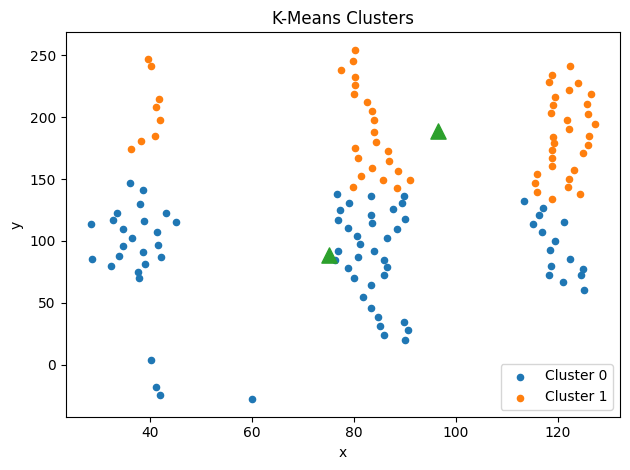

In [4]:
plot_clusters(coords, labels, centroids)

# Ortools for Benchmarking

In [5]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

SCALE = 1000  # presisi jarak

def _build_distance_matrix(nodes, use_D=True, scale=SCALE):
    N = len(nodes)
    if use_D:
        return [[int(round(scale * float(D[idx[nodes[i]], idx[nodes[j]]])))
                 for j in range(N)] for i in range(N)]
    else:
        return [[int(round(scale * get_weight(nodes[i], nodes[j])))
                 for j in range(N)] for i in range(N)]

def _remap_labels_to_vehicles(labels, starts_ids):
    """
    Pastikan indeks kendaraan 0..K-1 konsisten dengan urutan starts_ids.
    Kita buat mapping label_kluster -> vehicle_id berdasarkan label titik start tiap vehicle.
    """
    unique_from_starts = []
    for sid in starts_ids:
        unique_from_starts.append(labels[nodes.index(sid)])
    lbl_to_vid = {lbl: vid for vid, lbl in enumerate(unique_from_starts)}
    remapped = [lbl_to_vid[lbl] for lbl in labels]
    return remapped, lbl_to_vid

def create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids=None, scale=SCALE, use_D=True):
    """
    nodes: list ID node
    labels: label kluster (len == len(nodes)), sejajar dengan nodes
    starts_ids: list ID node start per vehicle (panjang K)
    ends_ids: list ID node end per vehicle (default = starts_ids)
    """
    assert len(nodes) == len(labels), "labels harus sejajar dengan nodes"
    K = len(starts_ids)
    if ends_ids is None:
        ends_ids = starts_ids[:]
    assert len(ends_ids) == K, "ends_ids harus sama panjang dengan starts_ids"

    # Remap label kluster -> vehicle index berdasar urutan starts
    labels_remap, lbl_to_vid = _remap_labels_to_vehicles(labels, starts_ids)

    # Validasi start/end ada di cluster/vehicle yang sesuai
    for v in range(K):
        sid = starts_ids[v]
        eid = ends_ids[v]
        assert sid in nodes and eid in nodes, "start/end harus ada di nodes"
        # Opsional: pastikan start/end berada di kluster kendaraan v (tidak wajib kalau kamu ingin fleksibel)
        # pass

    # Build distance matrix
    distance_matrix = _build_distance_matrix(nodes, use_D=use_D, scale=scale)

    # Allowed vehicles per node (node hanya boleh dilayani vehicle sesuai klusternya)
    node_allowed = {i: [int(labels_remap[i])] for i in range(len(nodes))}

    # Konversi starts/ends ke index internal (0..N-1)
    starts_idx = [nodes.index(x) for x in starts_ids]
    ends_idx   = [nodes.index(x) for x in ends_ids]

    return {
        "distance_matrix": distance_matrix,
        "num_vehicles": K,
        "starts": starts_idx,
        "ends": ends_idx,
        "node_allowed_vehicles": node_allowed,
        "nodes": nodes,
        "scale": scale,
    }

def _route_cost_from_matrix(route_node_indices, matrix):
    """Hitung cost (integer scaled) sepanjang rute (urutan node indices, termasuk akhir)."""
    cost = 0
    for a, b in zip(route_node_indices[:-1], route_node_indices[1:]):
        cost += matrix[a][b]
    return cost

def solve_vrp_clustered_custom(nodes, labels, starts_ids, ends_ids=None, timeout_s=60,
                               first_strategy="PATH_CHEAPEST_ARC",
                               metaheuristic="GUIDED_LOCAL_SEARCH",
                               use_D=True):
    data = create_data_model_clustered_custom(nodes, labels, starts_ids, ends_ids, use_D=use_D)

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['starts'],
                                           data['ends'])
    routing = pywrapcp.RoutingModel(manager)

    # Cost callback
    def distance_callback(from_index, to_index):
        f = manager.IndexToNode(from_index)
        t = manager.IndexToNode(to_index)
        return data['distance_matrix'][f][t]

    transit_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # Lock node -> vehicle sesuai kluster
    for node_id in range(len(nodes)):
        idx_index = manager.NodeToIndex(node_id)
        routing.SetAllowedVehiclesForIndex(data['node_allowed_vehicles'][node_id], idx_index)

    # Params pencarian
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = int(timeout_s)
    search_parameters.first_solution_strategy = getattr(
        routing_enums_pb2.FirstSolutionStrategy, first_strategy
    )
    search_parameters.local_search_metaheuristic = getattr(
        routing_enums_pb2.LocalSearchMetaheuristic, metaheuristic
    )

    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print("No solution found!")
        return None, [], float('inf')

    # Ekstrak rute & biaya per-vehicle
    routes_ids = []
    per_vehicle_cost_float = []
    total_scaled = 0

    for v in range(data['num_vehicles']):
        index = routing.Start(v)
        route_idx = []
        while not routing.IsEnd(index):
            route_idx.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route_idx.append(manager.IndexToNode(index))  # tambahkan end

        # Konversi ke ID
        route_ids = [data['nodes'][i] for i in route_idx]
        routes_ids.append(route_ids)

        # Hitung cost rute ini langsung dari matrix (scaled)
        c_scaled = _route_cost_from_matrix(route_idx, data['distance_matrix'])
        total_scaled += c_scaled
        per_vehicle_cost_float.append(c_scaled / float(data['scale']))

    total_cost_float = total_scaled / float(data['scale'])
    return routes_ids, per_vehicle_cost_float, total_cost_float

def solve_vrp_clustered_random_starts(nodes, labels, timeout_s=60, use_D=True,
                                      seed=None, round_trip=True):
    """
    Pilih node start secara acak di tiap kluster, lalu solve VRP per-kluster.
    Mengembalikan:
      - starts: list start ID per vehicle/cluster
      - routes: list rute (list of node IDs) per vehicle
      - per_costs: biaya per vehicle (float, unscaled)
      - total_cost: total biaya (float, unscaled)
    """
    rng = random.Random(seed)
    K = int(max(labels)) + 1

    # kumpulkan node per kluster
    clusters = {c: [] for c in range(K)}
    for n, lab in zip(nodes, labels):
        clusters[int(lab)].append(n)

    # pilih start random per kluster
    starts_ids = [rng.choice(clusters[c]) for c in range(K)]

    # end: default round trip ke start; kalau mau random end juga, ubah di bawah
    if round_trip:
        ends_ids = starts_ids
    else:
        ends_ids = [rng.choice(clusters[c]) for c in range(K)]

    routes, per_costs, total_cost = solve_vrp_clustered_custom(
        nodes, labels, starts_ids, ends_ids,
        timeout_s=timeout_s, use_D=use_D
    )

    return {
        "starts": starts_ids,
        "routes": routes,
        "per_costs": per_costs,
        "total_cost": total_cost
    }

In [6]:
res = solve_vrp_clustered_random_starts(nodes, labels, timeout_s=20, use_D=True, seed=None)
print("Start per kluster:", res["starts"])
print("Biaya per kluster:", res["per_costs"])
print("Total cost:", res["total_cost"])
for i, r in enumerate(res["routes"], 1):
    print(f"Rute kendaraan {i}:", r)

Start per kluster: [117, 105]
Biaya per kluster: [736.05, 574.145]
Total cost: 1310.195
Rute kendaraan 1: [117, 52, 29, 54, 110, 106, 15, 93, 62, 132, 112, 96, 37, 81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 67, 129, 50, 101, 43, 123, 1, 130, 71, 55, 30, 115, 47, 76, 88, 77, 20, 60, 16, 85, 6, 108, 41, 116, 69, 84, 8, 135, 53, 38, 78, 18, 58, 128, 44, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117]
Rute kendaraan 2: [105, 36, 91, 5, 97, 74, 39, 104, 113, 64, 25, 120, 70, 12, 92, 32, 66, 127, 2, 48, 75, 119, 98, 131, 13, 89, 33, 100, 126, 61, 45, 46, 19, 118, 68, 109, 121, 87, 28, 122, 73, 57, 134, 14, 102, 31, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105]


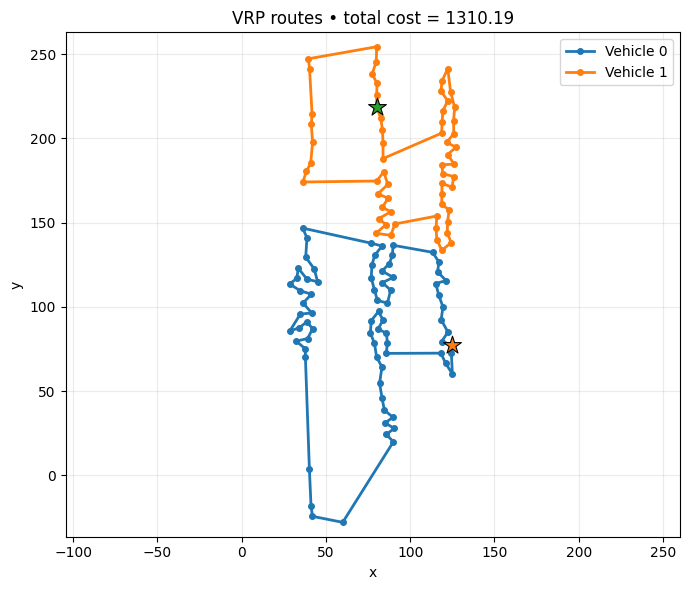

In [7]:
def _xy_of(node_id):
    # coords sejajar dengan `nodes`, dan `idx` memetakan id -> index
    return coords[idx[node_id], 0], coords[idx[node_id], 1]

def plot_routes_matplotlib(routes, starts=None, ends=None, show_ids=False, title="VRP routes"):
    fig, ax = plt.subplots(figsize=(7, 6))

    # plot semua titik sebagai background tipis
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.3, label="_all_points_bg")

    # gambar tiap rute
    for v, route in enumerate(routes):
        if len(route) == 0:
            continue

        # ambil koordinat sepanjang rute (termasuk node terakhir = end)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)

        # garis rutenya
        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Vehicle {v}")

        # tandai start & end
        s_id = starts[v] if starts is not None else route[0]
        e_id = ends[v]   if ends is not None   else route[-1]
        sx, sy = _xy_of(s_id)
        ex, ey = _xy_of(e_id)

        ax.scatter([sx],[sy], marker='*', s=180, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{v}")
        if e_id != s_id:
            ax.scatter([ex],[ey], marker='s', s=90, edgecolor='k', linewidths=0.8, zorder=5, label=f"_end_{v}")

        # optional: tulis ID di titik
        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_routes_matplotlib(
    routes=res["routes"],
    starts=res["starts"],
    ends=None,                # None -> otomatis dari list rute
    show_ids=False,
    title=f"VRP routes • total cost = {res['total_cost']:.2f}"
)

In [8]:
def plot_clustered_routes_matplotlib(cluster_routes, show_ids=False, title=None):
    fig, ax = plt.subplots(figsize=(7, 6))

    # background semua titik
    ax.scatter(coords[:,0], coords[:,1], s=10, alpha=0.25, label="_all_points_bg")

    for c, route in enumerate(cluster_routes):
        if not route:
            continue

        # urutan titik termasuk menutup ke awal (jika L>=2)
        xs, ys = [], []
        for nid in route:
            x, y = _xy_of(nid)
            xs.append(x); ys.append(y)
        if len(route) >= 2:
            x0, y0 = _xy_of(route[0])
            xs.append(x0); ys.append(y0)

        ax.plot(xs, ys, marker='o', linewidth=2, markersize=4, label=f"Cluster {c}")

        # tandai start (node pertama di list)
        sx, sy = _xy_of(route[0])
        ax.scatter([sx],[sy], marker='*', s=160, edgecolor='k', linewidths=0.8, zorder=5, label=f"_start_{c}")

        if show_ids:
            for nid in route:
                x, y = _xy_of(nid)
                ax.text(x, y, str(nid), fontsize=8, ha='right', va='bottom')

    if title is None:
        title = "Lovebird (clustered) routes"
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

# Lovebird Initial Algorithm

In [9]:
def swap_two(tour, i, j): # red
    new = tour[:]
    if j - i < 4:
        return interchange(new, i, j)

    mid = new[i:j+1]
    k = len(mid) // 2
    seg1 = mid[:k]
    seg2 = mid[k:]
    new[i:i+k] = seg2
    new[i+k:j+1] = seg1
    return new

def flip(tour, i, j): # peach
    new = tour[:]
    new[i:j+1] = reversed(new[i:j+1])
    return new

def interchange(tour, i, j): # green
    new = tour[:]
    new[i], new[j] = new[j], new[i]
    return new

def slide(tour, i, j): # yellow
    new = tour[:]
    city = new.pop(i)
    new.insert(j, city)
    return new

def guided_swap(tour, i, j): # blue
    new = flip(tour, i, j)
    return interchange(new, i, j)

def scramble(tour): # gray
    new = tour[:]
    random.shuffle(new)
    return new

In [10]:
# Fungsi untuk RouletteWheel (untuk pemilihan titik secara probabilistik)
def roulette_wheel(population, fitness):
    total_fitness = sum(fitness)
    selection = random.uniform(0, total_fitness)
    current_sum = 0
    for i, individual in enumerate(population):
        current_sum += fitness[i]
        if current_sum >= selection:
            return individual
    return population[-1]  # fallback jika tidak ada yang terpilih

In [11]:
# ==== helper: bangun mapping kluster -> daftar node (urut sesuai nodes) ====
def _clusters_from_labels(nodes, labels):
    K = int(max(labels)) + 1
    clusters = {c: [] for c in range(K)}
    for n, l in zip(nodes, labels):
        clusters[int(l)].append(n)
    return clusters, K

def lovebird_algorithm_clustered(labels, nodes, maxGeneration, popSize, seed=None):

    rng = random.Random(seed)
    EPS = 1e-12

    # bangun kluster -> daftar node (tetap fix; tidak ada perpindahan antar kluster)
    cluster_nodes, K = _clusters_from_labels(nodes, labels)

    # ---- inisialisasi populasi: permutasi acak per kluster ----
    def _random_individual():
        indiv = []
        for c in range(K):
            r = cluster_nodes[c][:]
            rng.shuffle(r)
            indiv.append(r)
        return indiv

    population = [_random_individual() for _ in range(popSize)]

    # biaya awal populasi (sekali jalan)
    pop_costs = [sum(total_distance(r) for r in ind) for ind in population]

    # best awal
    best_idx = min(range(popSize), key=lambda i: pop_costs[i])
    best_solution = [r[:] for r in population[best_idx]]
    best_fitness = pop_costs[best_idx]
    history = [best_fitness]

    # ---- GA Loop ----
    for g in range(maxGeneration):
        # fitness = 1/cost
        fitness = [1.0/c if c > 0 else 1e9 for c in pop_costs]

        new_population = []
        new_costs = []

        for _ in range(popSize):
            # -------- selection: roulette --------
            parent = roulette_wheel(population, fitness)

            # salin individu (list of routes)
            T = [r[:] for r in parent]

            # ----- mutation: pilih kluster acak, mutasi satu rute -----
            v = rng.randrange(K) if K > 0 else 0
            r = T[v]
            L = len(r)
            if L > 1:
                if rng.random() < 0.9 and L >= 2:
                    i_idx, j_idx = sorted(rng.sample(range(L), 2))
                    op = rng.choice([1, 2, 3, 4, 5])
                    if op == 1:
                        r = swap_two(r, i_idx, j_idx)
                    elif op == 2:
                        r = flip(r, i_idx, j_idx)
                    elif op == 3:
                        r = interchange(r, i_idx, j_idx)
                    elif op == 4:
                        r = slide(r, i_idx, j_idx)
                    else:
                        r = guided_swap(r, i_idx, j_idx)
                else:
                    r = scramble(r)
                T[v] = r

            # hitung biaya awal kandidat
            route_costs = [total_distance(rr) for rr in T]
            total_cost = float(sum(route_costs))

            # ---------- local search per kluster (first-improvement) ----------
            def _improve_route(route, current_cost):
                """apply SWAP lalu 2-OPT (FLIP) circular; return (route_baru, delta_total)"""
                Lr = len(route)
                if Lr <= 2:
                    return route, 0.0

                improved_outer = True
                total_delta = 0.0

                while improved_outer:
                    improved_outer = False

                    # ---- SWAP circular ----
                    made_swap = True
                    while made_swap:
                        made_swap = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                a_idx, c_idx = i, j
                                aL = route[(a_idx - 1) % Lr]
                                a  = route[a_idx]
                                b  = route[(a_idx + 1) % Lr]
                                cL = route[(c_idx - 1) % Lr]
                                c  = route[c_idx]
                                d  = route[(c_idx + 1) % Lr]

                                adjacent = (c_idx == a_idx + 1) or (a_idx == 0 and c_idx == Lr - 1)
                                if adjacent:
                                    if c_idx == a_idx + 1:
                                        old = D[idx[aL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[d]]
                                        new = D[idx[aL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[d]]
                                    else:
                                        old = D[idx[cL], idx[c]] + D[idx[c], idx[a]] + D[idx[a], idx[b]]
                                        new = D[idx[cL], idx[a]] + D[idx[a], idx[c]] + D[idx[c], idx[b]]
                                else:
                                    old = (D[idx[aL], idx[a]] + D[idx[a], idx[b]] +
                                           D[idx[cL], idx[c]] + D[idx[c], idx[d]])
                                    new = (D[idx[aL], idx[c]] + D[idx[c], idx[b]] +
                                           D[idx[cL], idx[a]] + D[idx[a], idx[d]])
                                delta = new - old
                                if delta < -EPS:
                                    route[a_idx], route[c_idx] = route[c_idx], route[a_idx]
                                    total_delta += delta
                                    made_swap = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_swap:
                            break  # restart

                    # ---- 2-OPT / FLIP circular ----
                    made_flip = True
                    while made_flip:
                        made_flip = False
                        if Lr <= 2:
                            break
                        accepted = False
                        i = 0
                        while i < Lr - 1 and not accepted:
                            j = i + 1
                            while j < Lr and not accepted:
                                if i == 0 and j == Lr - 1:
                                    j += 1
                                    continue
                                ap = route[(i - 1) % Lr]
                                a  = route[i]
                                c  = route[j]
                                dn = route[(j + 1) % Lr]
                                old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                                new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                                delta = new - old
                                if delta < -EPS:
                                    route[i:j+1] = reversed(route[i:j+1])
                                    total_delta += delta
                                    made_flip = True
                                    improved_outer = True
                                    accepted = True
                                else:
                                    j += 1
                            if not accepted:
                                i += 1
                        if made_flip:
                            break  # restart

                return route, total_delta

            # improve semua kluster
            for v in range(K):
                route_before = T[v]
                route_after, delta = _improve_route(route_before, route_costs[v])
                if delta != 0.0:
                    T[v] = route_after
                    route_costs[v] += delta
                    total_cost += delta

            new_population.append(T)
            new_costs.append(total_cost)

        # elitism
        gen_best_idx = min(range(popSize), key=lambda i: new_costs[i])
        if new_costs[gen_best_idx] < best_fitness - EPS:
            best_fitness = new_costs[gen_best_idx]
            best_solution = [r[:] for r in new_population[gen_best_idx]]

        population = new_population
        pop_costs  = new_costs
        history.append(best_fitness)

    # biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    # total (float)
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs


In [12]:
# labels = ...   # hasil KMeans, sejajar dengan nodes
best_sol_l, total_cost_l, hist_l, per_costs_l = lovebird_algorithm_clustered(
    labels, nodes, maxGeneration=10, popSize=10
)

print("Biaya per kluster:", per_costs_l)
print("Total biaya:", total_cost_l)
for i, r in enumerate(best_sol_l, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [749.7667250206672, 576.125316668542]
Total biaya: 1325.8920416892092
Rute kluster 1 (|r|=75): [23, 107, 34, 72, 40, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 128, 44, 108, 6, 41, 116, 18, 58, 78, 38, 69, 84, 53, 135, 8, 112, 132, 93, 15, 81, 37, 62, 96, 77, 88, 20, 16, 85, 60, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63]
Rute kluster 2 (|r|=60): [2, 66, 74, 39, 104, 64, 25, 120, 70, 113, 12, 92, 32, 127, 48, 98, 131, 13, 89, 33, 100, 68, 126, 61, 45, 46, 19, 118, 109, 121, 87, 28, 122, 73, 57, 134, 14, 83, 65, 7, 86, 22, 79, 35, 17, 56, 99, 9, 49, 94, 24, 105, 36, 91, 5, 97, 31, 102, 119, 75]


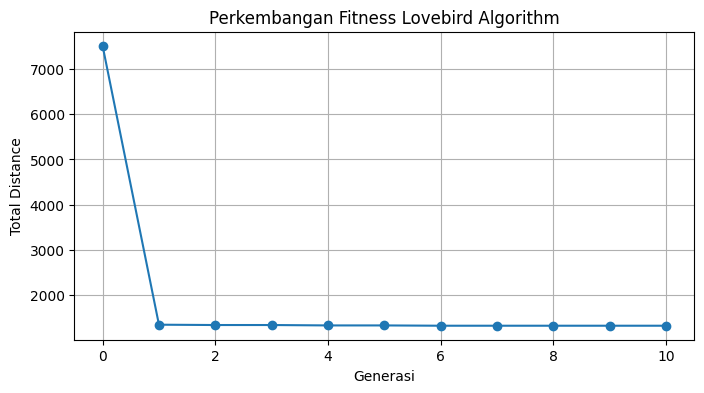

In [13]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_l, marker='o')
plt.title("Perkembangan Fitness Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

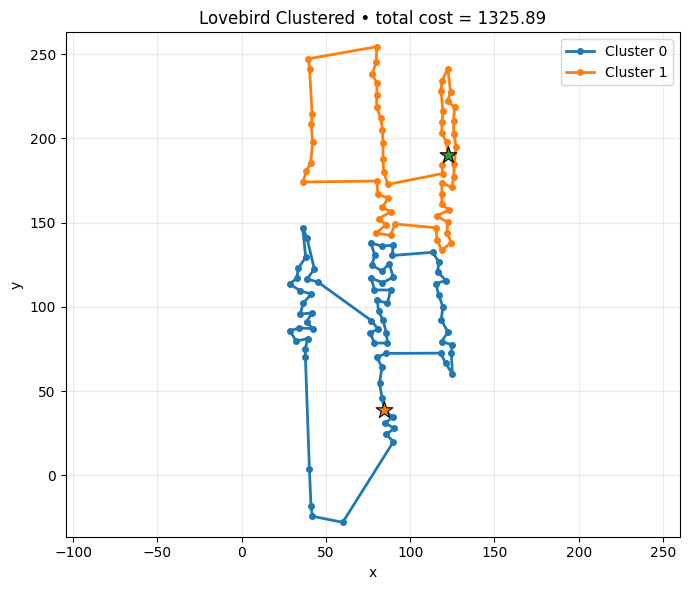

In [14]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_l,
    show_ids=False,
    title=f"Lovebird Clustered • total cost = {total_cost_l:.2f}"
)

# Local Lovebird Algorithm

In [46]:
def lovebird_local_search(
    maxLoop,
    clusters=None,               # <- optional: list of list node IDs per cluster
    labels=None, nodes=None,     # <- optional: jika ada labels dari KMeans + urutan nodes
    initial_solution=None,       # <- optional: seed awal (list of routes)
    time_budget=None,
    check_every=4096
):

    # --- util waktu ---
    t0 = time.perf_counter()
    def time_up():
        return (time_budget is not None) and ((time.perf_counter() - t0) >= time_budget)

    # --- bangun current (list of routes) sesuai prioritas input ---
    if clusters is not None:
        # deep copy, jaga urutan tiap kluster apa adanya
        current = [r[:] for r in clusters if len(r) > 0]
    elif (labels is not None) and (nodes is not None):
        # bangun kluster dari labels sesuai urutan nodes
        lab_arr = np.asarray(labels)
        K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
        tmp = {c: [] for c in range(K)}
        for n, l in zip(nodes, lab_arr):
            tmp[int(l)].append(n)
        current = [tmp[c] for c in range(K) if len(tmp[c]) > 0]
    elif initial_solution is not None:
        current = [r[:] for r in initial_solution if len(r) > 0]
    else:
        ids_copy = ids[:]
        random.shuffle(ids_copy)
        current = [ids_copy]  # fallback: satu kendaraan

    # Jika tidak ada rute, kembalikan trivial
    if len(current) == 0:
        return [], 0.0, [0.0], []

    # --- biaya awal ---
    route_costs = [total_distance(r) for r in current]
    total_cost  = float(sum(route_costs))
    best_solution = [r[:] for r in current]
    best_fitness = total_cost
    history = [best_fitness]

    EPS = 1e-12
    ops = 0  # throttle untuk pengecekan time_budget

    # # Eksplorasi/“mutasi ringan”: pilih satu rute acak, lakukan mutasi DI AWAL (flip/interchange/slide)
    # T = [r[:] for r in current]
    # v = random.randrange(len(T))
    # r = T[v]
    # if len(r) > 1:
    #     i_idx, j_idx = sorted(random.sample(range(len(r)), 2))
    #     op = random.choice([2, 3, 4])  # 2:flip, 3:interchange, 4:slide
    #     if op == 2:
    #         r = flip(r, i_idx, j_idx)
    #     elif op == 3:
    #         r = interchange(r, i_idx, j_idx)
    #     elif op == 4:
    #         r = slide(r, i_idx, j_idx)
    # T[v] = r
    # current = T

    # --- helper improve satu rute dengan 2-OPT circular (first-improvement) ---
    def _improve_route(route):
        L = len(route)
        if L <= 2:
            return 0.0  # delta total
        total_delta = 0.0
        improved = True
        while improved:
            improved = False
            accepted_outer = False
            i = 0
            while i < L - 1 and not accepted_outer:
                j = i + 1
                while j < L and not accepted_outer:
                    # throttle waktu
                    nonlocal ops
                    ops += 1
                    if (ops % check_every == 0) and time_up():
                        return total_delta  # keluar rapi: kembalikan delta yang sudah terjadi

                    # larang memotong edge yang sama (i=0, j=L-1) karena tour circular
                    if i == 0 and j == L - 1:
                        j += 1
                        continue

                    ap = route[(i - 1) % L]
                    a  = route[i]
                    c  = route[j]
                    dn = route[(j + 1) % L]

                    old = D[idx[ap], idx[a]] + D[idx[c], idx[dn]]
                    new = D[idx[ap], idx[c]] + D[idx[a], idx[dn]]
                    delta = new - old
                    if delta < -EPS:
                        route[i:j+1] = reversed(route[i:j+1])
                        total_delta += delta
                        improved = True
                        accepted_outer = True  # restart dari awal rute
                    else:
                        j += 1
                if not accepted_outer:
                    i += 1
        return total_delta

    # --- main loops ---
    for _ in range(maxLoop):
        if time_up():
            break

        # Turun bukit: improve SEMUA rute (per kluster) sampai lokal optimum
        any_improved = True
        while any_improved and (not time_up()):
            any_improved = False
            for v in range(len(current)):
                if time_up():
                    break
                delta = _improve_route(current[v])
                if abs(delta) > 0.0:
                    route_costs[v] += delta
                    total_cost += delta
                    any_improved = True

        # update best setelah satu fase improve
        if total_cost < best_fitness - EPS:
            best_fitness = float(total_cost)
            best_solution = [rr[:] for rr in current]

        if time_up():
            break

        # Eksplorasi/“mutasi ringan”: pilih satu rute acak, lakukan mutasi DI AKHIR (flip/interchange/slide)
        T = [r[:] for r in current]
        v = random.randrange(len(T))
        r = T[v]
        if len(r) > 1:
            i_idx, j_idx = sorted(random.sample(range(len(r)), 2))
            op = random.choice([2, 3, 4])  # 2:flip, 3:interchange, 4:slide
            if op == 2:
                r = flip(r, i_idx, j_idx)
            elif op == 3:
                r = interchange(r, i_idx, j_idx)
            elif op == 4:
                r = slide(r, i_idx, j_idx)
        T[v] = r
        current = T

        # Recompute biaya rute & total
        route_costs = [total_distance(rr) for rr in current]
        total_cost = float(sum(route_costs))
        history.append(best_fitness)

    # siapkan ringkasan biaya per kluster untuk best_solution
    per_cluster_costs = [total_distance(r) for r in best_solution]
    best_fitness = float(sum(per_cluster_costs))
    return best_solution, best_fitness, history, per_cluster_costs

In [47]:
best_sol_ll, total_cost_ll, hist_ll, per_costs_ll = lovebird_local_search(
    maxLoop=50,
    labels=labels,
    nodes=nodes,
    time_budget=10.0
)

print("Biaya per kluster:", per_costs_ll)
print("Total biaya:", total_cost_ll)
for i, r in enumerate(best_sol_ll, 1):
    print(f"Rute kluster {i} (|r|={len(r)}):", r)

Biaya per kluster: [743.2907606195482, 584.256003671504]
Total biaya: 1327.546764291052
Rute kluster 1 (|r|=75): [112, 8, 84, 69, 77, 88, 20, 60, 16, 85, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 106, 15, 81, 37, 62, 96, 132, 93, 10, 110, 54, 29, 52, 117, 80, 51, 27, 59, 125, 82, 3, 90, 114, 128, 44, 108, 6, 41, 116, 18, 58, 78, 38, 53, 135]
Rute kluster 2 (|r|=60): [122, 28, 87, 121, 109, 118, 19, 46, 45, 61, 126, 68, 100, 33, 89, 13, 131, 98, 119, 75, 48, 2, 127, 66, 32, 74, 39, 92, 104, 12, 113, 70, 120, 25, 64, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 91, 5, 97, 31, 83, 102, 14, 134, 57, 73]


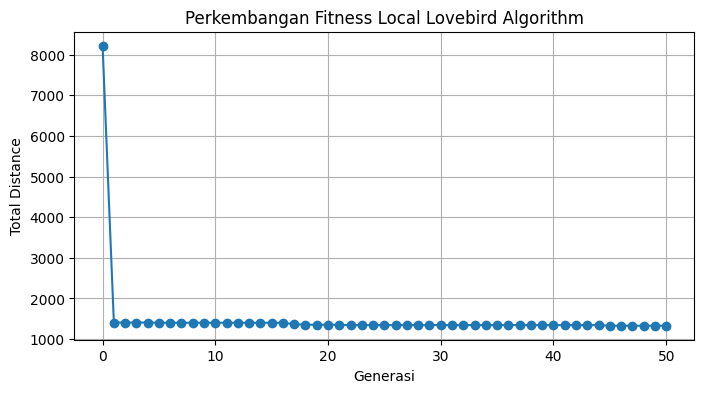

In [48]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ll, marker='o')
plt.title("Perkembangan Fitness Local Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

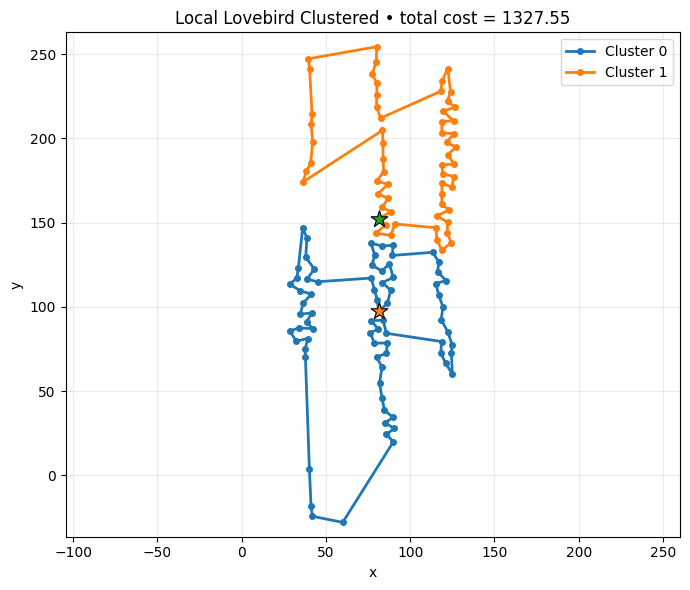

In [49]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ll,
    show_ids=False,
    title=f"Local Lovebird Clustered • total cost = {total_cost_ll:.2f}"
)

# Iterated Lovebird Algorithm

In [50]:
def double_bridge(route):
    L = len(route)
    if L < 8:
        return route[:]  # sama seperti semula
    rnd = random
    i1, i2, i3, i4 = sorted(rnd.sample(range(L), 4))
    segA = route[:i1]
    segB = route[i1:i2]
    segC = route[i2:i3]
    segD = route[i3:i4]
    segE = route[i4:]
    # varian klasik (tidak diubah)
    return segA + segC + segB + segD + segE


# --- 1) OR-Opt intra-route: pilih posisi sisip terbaik (circular, O(L)) ---
def or_opt_intra(route, k=2):
    L = len(route)
    if L < k + 2:
        return route[:]

    rnd = random
    Dm  = D
    ix  = idx

    # pilih blok [i..i+k-1] (tanpa wrap)
    i = rnd.randint(0, L - k - 1)
    a = route[i]
    b = route[i + k - 1]
    p = route[i - 1] if i > 0 else route[-1]
    n = route[i + k] if (i + k) < L else route[0]

    block    = route[i:i+k]
    residual = route[:i] + route[i+k:]
    M        = len(residual)

    # biaya pelepasan blok dari posisi lama (circular TSP)
    base_remove = -Dm[ix[p]][ix[a]] - Dm[ix[b]][ix[n]] + Dm[ix[p]][ix[n]]

    best_j = None
    best_delta = 0.0
    # sisip sebelum residual[j], j=0..M-1 mewakili sisi (x->y)
    for j in range(M):
        x = residual[j - 1] if j > 0 else residual[-1]
        y = residual[j]
        insert_cost = -Dm[ix[x]][ix[y]] + Dm[ix[x]][ix[a]] + Dm[ix[b]][ix[y]]
        delta = base_remove + insert_cost
        if delta < best_delta:
            best_delta = delta
            best_j = j

    if best_j is None:
        return route[:]  # tak ada perbaikan

    # sisipkan block di posisi terbaik
    new_route = residual[:best_j] + block + residual[best_j:]
    return new_route


def perturb_multi_simple(solution, p_intra=0.95, prefer_k3=False, max_block=6):

    sol = [r[:] for r in solution]
    rnd = random
    rrand = rnd.random

    # --- intra OR-Opt mayoritas ---
    did_intra = False
    if rrand() < p_intra:
        cand_idxs = [i for i, r in enumerate(sol) if len(r) >= 5]
        if cand_idxs:
            v = rnd.choice(cand_idxs)
            k = 3 if (prefer_k3 and len(sol[v]) >= 5) else 2
            sol[v] = or_opt_intra(sol[v], k=k)
            did_intra = True

    # --- strong shake: double-bridge hanya saat stagnan (prefer_k3 True) ---
    if prefer_k3 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        if len(sol[v2]) >= 8 and rrand() < 0.07:
            sol[v2] = double_bridge(sol[v2])

    # --- scramble kecil (5%) pada rute terpanjang ---
    if rrand() < 0.05 and sol:
        v2 = max(range(len(sol)), key=lambda t: len(sol[t]))
        L = len(sol[v2])
        if L >= 6:
            m = rnd.randint(3, min(max_block, L - 1))
            i = rnd.randint(0, L - m)
            sub = sol[v2][i:i+m]
            rnd.shuffle(sub)
            sol[v2] = sol[v2][:i] + sub + sol[v2][i+m:]

    return sol

In [51]:
# def iterated_lovebird(max_iter=30, local_gen=120,
#                       clusters=None,              # <- NEW: list of list node IDs per kluster
#                       labels=None, nodes=None,    # <- NEW: alternatif masukan
#                       initial_solution=None,      # seed awal (list of routes)
#                       patience=3, seed=None, budget_s=None
#                       ):

#     if seed is not None:
#         random.seed(seed)

#     # --- siapkan solusi awal yang menghormati kluster ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             # gunakan urutan apa adanya per kluster
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]
#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]
#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]
#         else:
#             ids_copy = ids[:]; random.shuffle(ids_copy)
#             return [ids_copy]  # single-route fallback

#     # alias
#     ls = lovebird_local_search

#     # --- time budget helper ---
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if budget_s is not None else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- LS awal: hormati input kluster/seed ---
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,        # <- pass sebagai clusters agar LS tetap intra-cluster
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0

#     # --- ILS loop ---
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         prefer_k3 = (no_improve >= patience)
#         max_block = 6 + 2 * (no_improve // patience)

#         # Perturbasi dari best; default intra-cluster (kecuali allow_inter_cluster=True)
#         perturbed = perturb_multi_simple(
#             best_sol,
#             p_intra=0.9,
#             prefer_k3=prefer_k3,
#             max_block=max_block
#         )

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # Local search lagi (tetap intra-cluster)
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         if imp_cost < best_cost - 1e-9:
#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#         else:
#             no_improve += 1

#         # Hard restart kecil saat buntu—tetap hormati kluster; boleh cross-move kalau diizinkan
#         if no_improve >= 2 * patience:
#             rem = time_left()
#             if rem is None or rem > SAFETY + 0.1:
#                 strong = perturb_multi_simple(
#                     best_sol, p_intra=0.3, prefer_k3=True, max_block=12
#                 )
#                 rem = time_left()
#                 if rem is not None and rem <= SAFETY:
#                     break

#                 best_sol2, best_cost2, _, _ = ls(
#                     maxLoop=local_gen,
#                     clusters=strong,
#                     time_budget=(rem - SAFETY) if rem is not None else None
#                 )
#                 if best_cost2 < best_cost - 1e-9:
#                     best_sol, best_cost = best_sol2, best_cost2
#                     no_improve = 0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history

In [52]:
def iterated_lovebird(
    max_iter=30,
    local_gen=120,
    clusters=None,           # list of list node IDs per kluster
    labels=None, nodes=None, # alternatif masukan
    initial_solution=None,   # seed awal (list of routes)
    seed=None,
    budget_s=None
):
    if seed is not None:
        random.seed(seed)

    # --- siapkan solusi awal yang menghormati kluster ---
    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]

        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]

        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]  # single-route fallback

    ls = lovebird_local_search

    # --- time budget helper (opsional) ---
    SAFETY   = 0.05
    t_start  = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # --- LS awal: hormati input kluster/seed ---
    start_solution = _init_solution_from_inputs()

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=start_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]

    # --- PURE ILS loop (tanpa adaptasi) ---
    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Perturbasi dari solusi terbaik saat ini
        # p_intra dan max_block konstan, tidak ada adaptasi
        perturbed = double_bridge(best_sol)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Local search lagi, intensitas tetap (local_gen)
        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        # Aturan penerimaan: hanya terima jika lebih baik
        if imp_cost < best_cost - 1e-9:
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost

        history.append(best_cost)

    return best_sol, float(best_cost), history


In [53]:
best_sol_il, best_cost_il, hist_il = iterated_lovebird(
    max_iter=20, local_gen=20,
    labels=labels, nodes=nodes,
    budget_s=10.0
)

# Ringkasan biaya
per_costs_il = [total_distance(r) for r in best_sol_il]  # biaya per kluster
total_cost_il = sum(per_costs_il)                         # sama dengan best_cost (cek konsistensi)

print("Biaya per kluster:", per_costs_il)
print("Total biaya (sum):", total_cost_il)
print("Total biaya (best_cost dari ILS):", best_cost_il)

# Cetak rute per kluster
for i, r in enumerate(best_sol_il, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [736.1523237436517, 575.239046465877]
Total biaya (sum): 1311.3913702095288
Total biaya (best_cost dari ILS): 1311.3913702095288
Rute kluster 1 (|r|=75): [16, 85, 6, 41, 108, 44, 128, 58, 18, 116, 69, 84, 8, 135, 53, 38, 78, 114, 90, 3, 82, 125, 59, 27, 51, 80, 10, 117, 52, 29, 54, 110, 106, 15, 93, 62, 132, 112, 96, 37, 81, 40, 72, 34, 107, 23, 63, 111, 133, 95, 4, 42, 103, 11, 26, 124, 21, 129, 67, 123, 43, 50, 101, 130, 1, 71, 55, 30, 115, 47, 88, 77, 20, 76, 60]
Rute kluster 2 (|r|=60): [57, 73, 122, 87, 121, 28, 109, 118, 19, 46, 45, 61, 126, 68, 100, 33, 89, 131, 98, 48, 127, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 66, 2, 75, 119, 13, 102, 83, 31, 97, 5, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 14, 134]


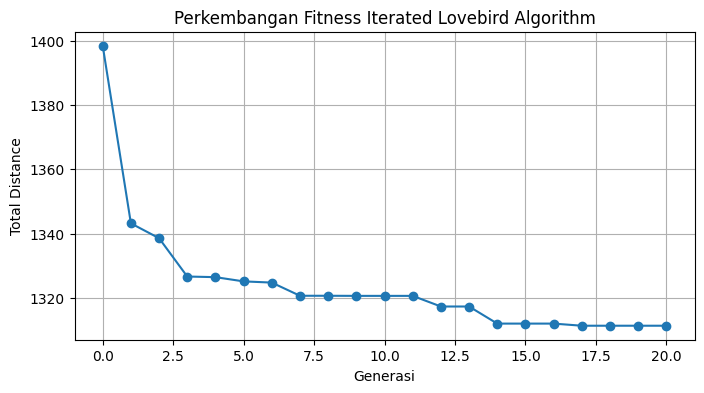

In [54]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_il, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

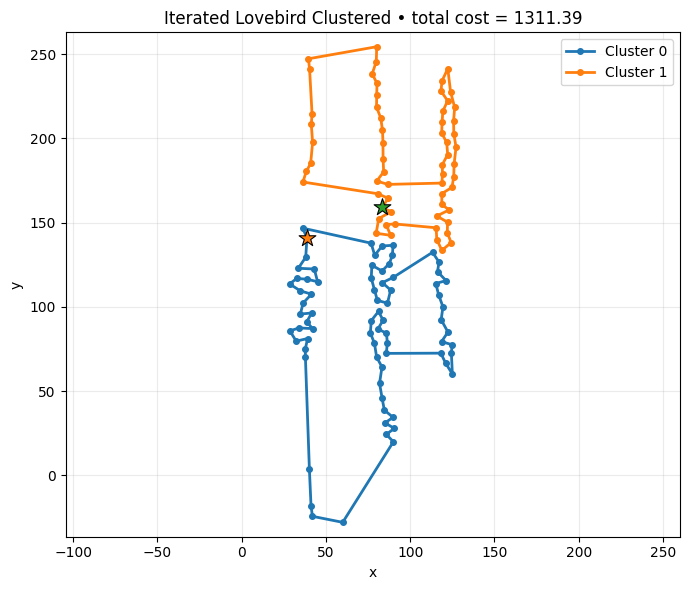

In [55]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_il,
    show_ids=False,
    title=f"Iterated Lovebird Clustered • total cost = {best_cost_il:.2f}"
)

# Hyper Iterated Lovebird Algorithm

In [56]:
# def or_opt_k1_once(route):

#     L = len(route)
#     if L < 3:
#         return route[:], 0.0, False

#     Dm = D
#     ix = idx
#     EPS = 1e-12

#     # Precompute index D untuk semua node di route (hemat lookup)
#     r_ix = [ix[n] for n in route]

#     best_delta = 0.0
#     best_move  = None  # (i, y_idx_target) => sisip sebelum node di posisi y_idx_target (setelah pop)

#     for i in range(L):
#         a_idx = i
#         a = route[a_idx]; ia = r_ix[a_idx]

#         p_idx = a_idx - 1 if a_idx > 0 else L - 1
#         n_idx = a_idx + 1 if (a_idx + 1) < L else 0

#         ip = r_ix[p_idx]; inn = r_ix[n_idx]

#         # Lepas a: (p->a, a->n) jadi (p->n)
#         base_remove = -Dm[ip][ia] - Dm[ia][inn] + Dm[ip][inn]

#         # 1) Cek semua sisi (x->y) dari tur asli KECUALI yang menyentuh a
#         #    (yaitu j == a_idx-1 => (p->a) dan j == a_idx => (a->n))
#         j = 0
#         while j < L:
#             if j != p_idx and j != a_idx:
#                 x_idx = j
#                 y_idx = j + 1 if (j + 1) < L else 0
#                 ix_x = r_ix[x_idx]; ix_y = r_ix[y_idx]

#                 insert_cost = -Dm[ix_x][ix_y] + Dm[ix_x][ia] + Dm[ia][ix_y]
#                 delta = base_remove + insert_cost
#                 if delta < best_delta - EPS:
#                     # sisip sebelum 'y' di list SETELAH a di-pop
#                     ins_pos = y_idx - (1 if y_idx > a_idx else 0)
#                     best_delta = delta
#                     best_move  = (a_idx, ins_pos)
#             j += 1

#         # 2) Tambahkan sisi (p->n) yang muncul setelah a dilepas
#         #    (setara dengan sisip sebelum 'n' pada list setelah pop)
#         insert_cost_pn = -Dm[ip][inn] + Dm[ip][ia] + Dm[ia][inn]
#         delta_pn = base_remove + insert_cost_pn
#         if delta_pn < best_delta - EPS:
#             # sisip sebelum 'n' pada list SETELAH pop
#             # posisi 'n' di list baru: jika n_idx > a_idx → n_idx-1, else n_idx
#             ins_pos = n_idx - (1 if n_idx > a_idx else 0)
#             best_delta = delta_pn
#             best_move  = (a_idx, ins_pos)

#     if best_move is None:
#         return route[:], 0.0, False

#     # Bangun rute baru sesuai best_move (pop + insert)
#     i_pop, ins_pos = best_move
#     new_route = route[:]             # salin ringan
#     node = new_route.pop(i_pop)
#     new_route.insert(ins_pos, node)
#     return new_route, best_delta, True

In [57]:
# # DEFAULT HYPER ILS

# def hyper_iterated_lovebird(
#     max_iter=10,
#     local_gen_shallow=8,
#     local_gen_deep=30,
#     deep_every=3,
#     patience=2,
#     initial_solution=None,
#     p_intra=0.95,
#     base_max_block=6,
#     budget_s=None,
#     seed=None,
#     # NEW ↓↓↓
#     clusters=None,             # list of list node IDs per cluster
#     labels=None, nodes=None,   # alternatif masukan (hasil KMeans)
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- builder solusi awal dari input kluster/label ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]
#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]
#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]
#         else:
#             ids_copy = ids[:]; random.shuffle(ids_copy)
#             return [ids_copy]  # fallback single-route

#     t_start = time.perf_counter()
#     deadline = (t_start + budget_s) if budget_s is not None else None
#     SAFETY = 0.05

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- start solution (menghormati kluster) ---
#     start_solution = _init_solution_from_inputs()

#     # Waktu terlalu sempit → kembalikan cepat
#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     # LS awal (cluster-aware)
#     sol0, cost0, _, _ = lovebird_local_search(
#         maxLoop=max(local_gen_deep, 10),
#         clusters=start_solution,                           # <-- penting
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     best_sol, best_cost = sol0, cost0
#     history = [best_cost]
#     no_improve = 0

#     elite  = [(best_cost, [r[:] for r in best_sol])]
#     ELITE_K = 3

#     for it in range(1, max_iter + 1):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         prefer_k3 = (no_improve >= patience)
#         max_block = base_max_block + 2 * (no_improve // patience)

#         # Perturb dari best (default intra-kluster)
#         perturbed = perturb_multi_simple(
#             best_sol,
#             p_intra=p_intra,
#             prefer_k3=prefer_k3,
#             max_block=max_block,
#         )

#         # --- similarity guard (ringan) ---
#         def _hamming_routes(A, B):
#             diff = 0
#             for ra, rb in zip(A, B):
#                 m = min(len(ra), len(rb))
#                 for i in range(m):
#                     if ra[i] != rb[i]:
#                         diff += 1
#                 diff += abs(len(ra) - len(rb))
#             return diff

#         total_n = sum(len(r) for r in best_sol)
#         BASE_FRAC  = 0.05
#         EARLY_FRAC = 0.08
#         MID_FRAC   = 0.08
#         MIN_DIFF = max(8, int(BASE_FRAC * total_n))
#         plateau_after = max(3, 2 * patience)

#         diff = _hamming_routes(perturbed, best_sol)
#         need = MIN_DIFF
#         if it <= 2:
#             need = max(need, int(EARLY_FRAC * total_n))
#         elif no_improve >= plateau_after:
#             need = max(need, int(MID_FRAC * total_n))

#         if diff < need:
#             perturbed = perturb_multi_simple(
#                 best_sol,
#                 p_intra=max(0.6, p_intra - 0.2),
#                 prefer_k3=True,
#                 max_block=min(12, base_max_block + 2),
#             )

#         use_deep = (it % deep_every == 0) or (no_improve >= patience)
#         depth = local_gen_deep if use_deep else local_gen_shallow

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # # pre-repair: 1 langkah OR-Opt k=1 per route
#         # for v in range(len(perturbed)):
#         #     new_r, delta, ok = or_opt_k1_once(perturbed[v])
#         #     if ok:
#         #         perturbed[v] = new_r

#         FINISHER_TAIL = 1.0
#         remaining_iter = max(1, max_iter - it + 1)
#         MIN_BUDGET_SHALLOW = 0.50
#         MIN_BUDGET_DEEP    = 1.25

#         if rem is None:
#             ls_budget = None
#         else:
#             usable = max(0.0, rem - max(SAFETY, FINISHER_TAIL))
#             slot = usable / remaining_iter if remaining_iter > 0 else usable
#             slot *= (1.6 if use_deep else 1.0)
#             floor_need = MIN_BUDGET_DEEP if use_deep else MIN_BUDGET_SHALLOW
#             slot = max(slot, floor_need)
#             ls_budget = max(0.0, min(slot, usable - 0.01))

#         # LS iterasi (cluster-aware)
#         sol, cost, _, _ = lovebird_local_search(
#             maxLoop=depth,
#             clusters=perturbed,                               # <-- penting
#             time_budget=ls_budget
#         )

#         if all(abs(cost - c0) > 1e-7 for c0, _ in elite):
#             elite.append((cost, [r[:] for r in sol]))
#             elite.sort(key=lambda x: x[0])
#             if len(elite) > ELITE_K:
#                 elite.pop()

#         if cost < best_cost - 1e-9:
#             best_sol, best_cost = sol, cost
#             no_improve = 0
#         else:
#             no_improve += 1
#             rem = time_left()
#             if (no_improve >= 2 * patience) and (rem is None or rem > SAFETY + 0.1):
#                 strong = perturb_multi_simple(
#                     best_sol,
#                     p_intra=0.6,
#                     prefer_k3=True,
#                     max_block=min(12, base_max_block + 4),
#                 )
#                 rem = time_left()
#                 if rem is not None and rem <= SAFETY:
#                     break
#                 sol2, cost2, _, _ = lovebird_local_search(
#                     maxLoop=local_gen_deep,
#                     clusters=strong,                              # <-- penting
#                     time_budget=(rem - SAFETY) if rem is not None else None
#                 )
#                 if cost2 < best_cost - 1e-9:
#                     best_sol, best_cost = sol2, cost2
#                     no_improve = 0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history


In [58]:
# # HYPER ILS MODIFIED (BEST CONFIG YET)

# def hyper_iterated_lovebird(
#     max_iter=10,
#     local_gen_shallow=8,
#     local_gen_deep=30,
#     deep_every=3,
#     patience=2,
#     initial_solution=None,
#     p_intra=0.95,
#     base_max_block=6,
#     budget_s=None,
#     seed=None,
#     # NEW ↓↓↓
#     clusters=None,             # list of list node IDs per cluster
#     labels=None, nodes=None,   # alternatif masukan (hasil KMeans)
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- builder solusi awal dari input kluster/label ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]
#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]
#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]
#         else:
#             ids_copy = ids[:]; random.shuffle(ids_copy)
#             return [ids_copy]  # fallback single-route

#     t_start = time.perf_counter()
#     deadline = (t_start + budget_s) if budget_s is not None else None
#     SAFETY = 0.05

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- start solution (menghormati kluster) ---
#     start_solution = _init_solution_from_inputs()

#     # Waktu terlalu sempit → kembalikan cepat
#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     # LS awal (cluster-aware) — pakai sisa waktu global apa adanya
#     ls_budget0 = time_left()
#     if ls_budget0 is not None and ls_budget0 <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     sol0, cost0, _, _ = lovebird_local_search(
#         maxLoop=max(local_gen_deep, 10),
#         clusters=start_solution,                           # <-- penting
#         time_budget=ls_budget0    # <--- tidak ada pembagian per segmen, langsung pakai sisa waktu
#     )
#     best_sol, best_cost = sol0, cost0
#     history = [best_cost]
#     no_improve = 0

#     for it in range(1, max_iter + 1):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         prefer_k3 = (no_improve >= patience)
#         max_block = base_max_block + 2 * (no_improve // patience)

#         # Perturb dari best (default intra-kluster)
#         perturbed = perturb_multi_simple(
#             best_sol,
#             p_intra=p_intra,
#             prefer_k3=prefer_k3,
#             max_block=max_block,
#         )

#         # --- similarity guard (ringan) ---
#         def _hamming_routes(A, B):
#             diff = 0
#             for ra, rb in zip(A, B):
#                 m = min(len(ra), len(rb))
#                 for i in range(m):
#                     if ra[i] != rb[i]:
#                         diff += 1
#                 diff += abs(len(ra) - len(rb))
#             return diff

#         total_n = sum(len(r) for r in best_sol)
#         BASE_FRAC  = 0.05
#         EARLY_FRAC = 0.08
#         MID_FRAC   = 0.08
#         MIN_DIFF = max(8, int(BASE_FRAC * total_n))
#         plateau_after = max(3, 2 * patience)

#         diff = _hamming_routes(perturbed, best_sol)
#         need = MIN_DIFF
#         if it <= 2:
#             need = max(need, int(EARLY_FRAC * total_n))
#         elif no_improve >= plateau_after:
#             need = max(need, int(MID_FRAC * total_n))

#         if diff < need:
#             perturbed = perturb_multi_simple(
#                 best_sol,
#                 p_intra=max(0.6, p_intra - 0.2),
#                 prefer_k3=True,
#                 max_block=min(12, base_max_block + 2),
#             )

#         use_deep = (it % deep_every == 0) or (no_improve >= patience)
#         depth = local_gen_deep if use_deep else local_gen_shallow

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # --- SIMPLE GLOBAL TIME USE ---
#         ls_budget = time_left()
#         if ls_budget is not None and ls_budget <= SAFETY:
#             break

#         # LS iterasi (cluster-aware) dengan sisa waktu global langsung
#         sol, cost, _, _ = lovebird_local_search(
#             maxLoop=depth,
#             clusters=perturbed,                               # <-- penting
#             time_budget=ls_budget
#         )

#         if cost < best_cost - 1e-9:
#             best_sol, best_cost = sol, cost
#             no_improve = 0
#         else:
#             no_improve += 1

#         history.append(best_cost)

#     return best_sol, float(best_cost), history

In [94]:
# def hyper_iterated_lovebird(
#     max_iter=30,
#     local_gen=30,
#     clusters=None,           # list of list node IDs per kluster
#     labels=None, nodes=None, # alternatif masukan
#     initial_solution=None,   # seed awal (list of routes)
#     seed=None,
#     budget_s=None,
#     base_max_block=6,        # untuk scramble
#     patience=3               # berapa iterasi tanpa perbaikan sebelum "strong mode"
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- siapkan solusi awal yang menghormati kluster ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]

#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]

#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]

#         else:
#             ids_copy = ids[:]
#             random.shuffle(ids_copy)
#             return [ids_copy]  # single-route fallback

#     ls = lovebird_local_search

#     # --- helper: Hamming distance antar solusi (sama seperti Tahap 1) ---
#     def _hamming_routes(sol_a, sol_b):
#         diff = 0
#         Ra = len(sol_a)
#         Rb = len(sol_b)
#         R  = min(Ra, Rb)

#         # bandingkan rute yang sama-sama ada
#         for k in range(R):
#             ra = sol_a[k]
#             rb = sol_b[k]
#             m = min(len(ra), len(rb))
#             for i in range(m):
#                 if ra[i] != rb[i]:
#                     diff += 1
#             diff += abs(len(ra) - len(rb))

#         # rute sisa dianggap beda penuh
#         if Ra > Rb:
#             for k in range(R, Ra):
#                 diff += len(sol_a[k])
#         elif Rb > Ra:
#             for k in range(R, Rb):
#                 diff += len(sol_b[k])

#         return diff

#     # =========
#     #  OPERATOR (MILD)
#     # =========
#     def _op_double_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 5]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=2)
#         return new_sol

#     def _op_or3_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_scramble_mild(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         m = random.randint(3, min(base_max_block, L - 1))
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # =========
#     #  OPERATOR (STRONG MODE – saat stagnasi)
#     # =========
#     def _op_double_strong(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 10]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         # aplikasi double bridge 1–2 kali (shake lebih kuat)
#         new_sol[v] = double_bridge(new_sol[v])
#         if len(new_sol[v]) >= 12 and random.random() < 0.5:
#             new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_strong(sol):
#         # or-opt tapi lebih "tebal": pakai k=3
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_or3_strong(sol):
#         # dua kali or-opt k=3 di rute yang sama
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_scramble_strong(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         # blok scramble lebih besar
#         max_blk = min(base_max_block * 2, L - 1)
#         m = random.randint(3, max_blk)
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # mapping nama → operator (mild dan strong pakai nama yang sama)
#     operators_mild = {
#         "double":   _op_double_mild,
#         "or2":      _op_or2_mild,
#         "or3":      _op_or3_mild,
#         "scramble": _op_scramble_mild,
#     }
#     operators_strong = {
#         "double":   _op_double_strong,
#         "or2":      _op_or2_strong,
#         "or3":      _op_or3_strong,
#         "scramble": _op_scramble_strong,
#     }

#     # bobot operator (dipakai di kedua mode)
#     weights = {name: 1.0 for name in operators_mild}

#     # roulette wheel
#     def _choose_operator(weights_dict):
#         names = list(weights_dict.keys())
#         total_w = sum(weights_dict.values())
#         if total_w <= 0:
#             return random.choice(names)
#         r = random.random() * total_w
#         acc = 0.0
#         for name in names:
#             acc += weights_dict[name]
#             if acc >= r:
#                 return name
#         return names[-1]

#     # parameter adaptasi bobot
#     REWARD_INC = 2.0
#     DECAY      = 0.95
#     W_MIN      = 0.1
#     W_MAX      = 10.0

#     # --- time budget helper (opsional) ---
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if (budget_s is not None) else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- LS awal ---
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0  # <--- kunci adaptasi intensitas

#     total_nodes = sum(len(r) for r in best_sol)
#     LOW_FRAC  = 0.05
#     HIGH_FRAC = 0.20
#     low_thresh  = max(3, int(LOW_FRAC  * total_nodes))
#     high_thresh = max(low_thresh + 1, int(HIGH_FRAC * total_nodes))

#     # --- AILS loop ---
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # pilih mode berdasarkan stagnasi
#         strong_mode = (no_improve >= patience)
#         op_dict = operators_strong if strong_mode else operators_mild

#         # 1) pilih operator berdasar bobot
#         op_name = _choose_operator(weights)
#         op_func = op_dict[op_name]

#         # 2) perturbasi
#         perturbed = op_func(best_sol)

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # 3) local search
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # 4) hamming distance (untuk penalti kalau terlalu mirip)
#         dist = _hamming_routes(imp_sol, best_sol)

#         # 5) update bobot & stagnasi
#         if imp_cost < best_cost - 1e-9:
#             # improvement → reward operator + reset stagnasi
#             weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#         else:
#             # tidak membaik → decay ringan
#             weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             # kalau gerakan kecil banget dan gagal → decay ekstra
#             if dist < low_thresh:
#                 weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             no_improve += 1

#         # 6) normalisasi ringan
#         total_w = sum(weights.values())
#         if total_w > 0 and total_w > len(weights) * W_MAX * 0.8:
#             for k in weights:
#                 weights[k] /= 2.0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history

In [ ]:
# def hyper_iterated_lovebird( 
#     max_iter=30,
#     local_gen=30,
#     clusters=None,           # list of list node IDs per kluster
#     labels=None, nodes=None, # alternatif masukan
#     initial_solution=None,   # seed awal (list of routes)
#     seed=None,
#     budget_s=None,
#     base_max_block=6,        # untuk scramble
#     patience=3               # berapa iterasi tanpa perbaikan sebelum "strong mode"
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- siapkan solusi awal yang menghormati kluster ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]

#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]

#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]

#         else:
#             ids_copy = ids[:]
#             random.shuffle(ids_copy)
#             return [ids_copy]  # single-route fallback

#     ls = lovebird_local_search

#     # --- helper: Hamming distance antar solusi ---
#     def _hamming_routes(sol_a, sol_b):
#         diff = 0
#         Ra = len(sol_a)
#         Rb = len(sol_b)
#         R  = min(Ra, Rb)

#         # bandingkan rute yang sama-sama ada
#         for k in range(R):
#             ra = sol_a[k]
#             rb = sol_b[k]
#             m = min(len(ra), len(rb))
#             for i in range(m):
#                 if ra[i] != rb[i]:
#                     diff += 1
#             diff += abs(len(ra) - len(rb))

#         # rute sisa dianggap beda penuh
#         if Ra > Rb:
#             for k in range(R, Ra):
#                 diff += len(sol_a[k])
#         elif Rb > Ra:
#             for k in range(R, Rb):
#                 diff += len(sol_b[k])

#         return diff

#     # =========
#     #  OPERATOR (MILD)
#     # =========
#     def _op_double_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_mild(sol):
#         """Satu langkah OR-Opt k=2 pada rute acak (lembut)."""
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 5]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=2)
#         return new_sol

#     def _op_or3_mild(sol):
#         """
#         DULU: OR-Opt k=3.
#         SEKARANG: 'multi-OR2' → 2x OR-Opt k=2 pada rute yang sama
#         (sedikit lebih kuat dari or2_mild, tapi masih mild).
#         """
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         route = new_sol[v]
#         route = or_opt_intra(route, k=2)
#         route = or_opt_intra(route, k=2)
#         new_sol[v] = route
#         return new_sol

#     def _op_scramble_mild(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         m = random.randint(3, min(base_max_block, L - 1))
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # =========
#     #  OPERATOR (STRONG MODE – saat stagnasi)
#     # =========
#     def _op_double_strong(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 10]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = double_bridge(new_sol[v])
#         if len(new_sol[v]) >= 12 and random.random() < 0.5:
#             new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_strong(sol):
#         """
#         DULU: OR-Opt k=3 (lebih agresif).
#         SEKARANG: 2x OR-Opt k=2 pada rute yang sama (versi kuat dari or2_mild).
#         """
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         route = new_sol[v]
#         route = or_opt_intra(route, k=2)
#         route = or_opt_intra(route, k=2)
#         new_sol[v] = route
#         return new_sol

#     def _op_or3_strong(sol):
#         """
#         DULU: 2x OR-Opt k=3.
#         SEKARANG: 'multi-OR2 strong' → 3x OR-Opt k=2 pada rute yang sama
#         (paling agresif di keluarga OR-Opt).
#         """
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         route = new_sol[v]
#         route = or_opt_intra(route, k=2)
#         route = or_opt_intra(route, k=2)
#         route = or_opt_intra(route, k=2)
#         new_sol[v] = route
#         return new_sol

#     def _op_scramble_strong(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         # blok scramble lebih besar
#         max_blk = min(base_max_block * 2, L - 1)
#         m = random.randint(3, max_blk)
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # mapping nama → operator (mild dan strong pakai nama yang sama)
#     operators_mild = {
#         "double":   _op_double_mild,
#         "or2":      _op_or2_mild,
#         "or3":      _op_or3_mild,      # sekarang = multi-OR2 mild
#         "scramble": _op_scramble_mild,
#     }
#     operators_strong = {
#         "double":   _op_double_strong,
#         "or2":      _op_or2_strong,    # 2x OR2
#         "or3":      _op_or3_strong,    # 3x OR2
#         "scramble": _op_scramble_strong,
#     }

#     # bobot operator (dipakai di kedua mode)
#     weights = {name: 1.0 for name in operators_mild}

#     # roulette wheel
#     def _choose_operator(weights_dict):
#         names = list(weights_dict.keys())
#         total_w = sum(weights_dict.values())
#         if total_w <= 0:
#             return random.choice(names)
#         r = random.random() * total_w
#         acc = 0.0
#         for name in names:
#             acc += weights_dict[name]
#             if acc >= r:
#                 return name
#         return names[-1]

#     # parameter adaptasi bobot
#     REWARD_INC = 2.0
#     DECAY      = 0.95
#     W_MIN      = 0.1
#     W_MAX      = 10.0

#     # --- time budget helper (opsional) ---
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if (budget_s is not None) else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- LS awal ---
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0  # <--- kunci adaptasi intensitas

#     total_nodes = sum(len(r) for r in best_sol)
#     LOW_FRAC  = 0.05
#     HIGH_FRAC = 0.20
#     low_thresh  = max(3, int(LOW_FRAC  * total_nodes))
#     high_thresh = max(low_thresh + 1, int(HIGH_FRAC * total_nodes))

#     # --- AILS loop ---
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # pilih mode berdasarkan stagnasi
#         strong_mode = (no_improve >= patience)
#         op_dict = operators_strong if strong_mode else operators_mild

#         # 1) pilih operator berdasar bobot
#         op_name = _choose_operator(weights)
#         op_func = op_dict[op_name]

#         # 2) perturbasi
#         perturbed = op_func(best_sol)

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # 3) local search
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # 4) hamming distance (untuk penalti kalau terlalu mirip)
#         dist = _hamming_routes(imp_sol, best_sol)

#         # 5) update bobot & stagnasi
#         if imp_cost < best_cost - 1e-9:
#             # improvement → reward operator + reset stagnasi
#             weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#         else:
#             # tidak membaik → decay ringan
#             weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             # kalau gerakan kecil banget dan gagal → decay ekstra
#             if dist < low_thresh:
#                 weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             no_improve += 1

#         # 6) normalisasi ringan
#         total_w = sum(weights.values())
#         if total_w > 0 and total_w > len(weights) * W_MAX * 0.8:
#             for k in weights:
#                 weights[k] /= 2.0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history


In [ ]:
# def hyper_iterated_lovebird(
#     max_iter=30,
#     local_gen=30,
#     clusters=None,           # list of list node IDs per kluster
#     labels=None, nodes=None, # alternatif masukan
#     initial_solution=None,   # seed awal (list of routes)
#     seed=None,
#     budget_s=None,
#     base_max_block=6,
#     patience=3
# ):
#     if seed is not None:
#         random.seed(seed)

#     # =========================
#     # 1. Solusi awal (cluster-aware)
#     # =========================
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]

#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]

#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]

#         else:
#             ids_copy = ids[:]
#             random.shuffle(ids_copy)
#             return [ids_copy]  # single-route fallback

#     ls = lovebird_local_search

#     # =========================
#     # 2. Hamming distance antar solusi (robust)
#     # =========================
#     def _hamming_routes(sol_a, sol_b):
#         diff = 0
#         Ra = len(sol_a)
#         Rb = len(sol_b)
#         R  = min(Ra, Rb)

#         # bandingkan rute yang sama-sama ada
#         for k in range(R):
#             ra = sol_a[k]
#             rb = sol_b[k]
#             m = min(len(ra), len(rb))
#             for i in range(m):
#                 if ra[i] != rb[i]:
#                     diff += 1
#             diff += abs(len(ra) - len(rb))

#         # rute sisa dianggap beda penuh
#         if Ra > Rb:
#             for k in range(R, Ra):
#                 diff += len(sol_a[k])
#         elif Rb > Ra:
#             for k in range(R, Rb):
#                 diff += len(sol_b[k])

#         return diff

#     # =========================
#     # 3. Operator dengan "strength" adaptif
#     # =========================
#     S_MIN, S_MAX = 1, 4   # batas bawah/atas intensitas

#     def _op_double(sol, strength=1):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)

#         times = min(max(strength, S_MIN), S_MAX)
#         for _ in range(times):
#             if len(new_sol[v]) < 8:
#                 break
#             new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2(sol, strength=1):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 4]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)

#         times = min(max(strength, S_MIN), S_MAX)
#         route = new_sol[v]
#         for _ in range(times):
#             if len(route) < 4:
#                 break
#             route = or_opt_intra(route, k=2)
#         new_sol[v] = route
#         return new_sol

#     def _op_or3(sol, strength=1):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 5]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)

#         times = min(max(strength, S_MIN), S_MAX)
#         route = new_sol[v]
#         for _ in range(times):
#             if len(route) < 5:
#                 break
#             route = or_opt_intra(route, k=3)
#         new_sol[v] = route
#         return new_sol

#     def _op_scramble(sol, strength=1):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol

#         # strength mempengaruhi panjang blok yang diacak
#         factor = 1.0 + 0.5 * (max(strength, S_MIN) - 1)
#         max_blk = min(int(base_max_block * factor), L - 1)
#         if max_blk < 3:
#             return new_sol

#         m = random.randint(3, max_blk)
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     operators = {
#         "double":   _op_double,
#         "or2":      _op_or2,
#         "or3":      _op_or3,
#         "scramble": _op_scramble,
#     }

#     # bobot pilihan operator
#     weights = {name: 1.0 for name in operators}
#     # intensitas per operator
#     strength = {name: 1 for name in operators}

#     # roulette wheel
#     def _choose_operator(weights_dict):
#         names = list(weights_dict.keys())
#         total_w = sum(weights_dict.values())
#         if total_w <= 0:
#             return random.choice(names)
#         r = random.random() * total_w
#         acc = 0.0
#         for name in names:
#             acc += weights_dict[name]
#             if acc >= r:
#                 return name
#         return names[-1]

#     # parameter adaptasi bobot
#     REWARD_INC = 2.0
#     DECAY      = 0.95
#     W_MIN      = 0.1
#     W_MAX      = 10.0

#     # =========================
#     # 4. Time budget global (bukan per tahap)
#     # =========================
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if (budget_s is not None) else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # =========================
#     # 5. LS awal
#     # =========================
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0

#     # threshold Hamming untuk "pergerakan terlalu kecil / terlalu besar"
#     total_nodes = sum(len(r) for r in best_sol)
#     LOW_FRAC  = 0.05   # <5% node berubah → terlalu kecil
#     HIGH_FRAC = 0.20   # >20% node berubah → terlalu besar
#     low_thresh  = max(3, int(LOW_FRAC  * total_nodes))
#     high_thresh = max(low_thresh + 1, int(HIGH_FRAC * total_nodes))

#     # =========================
#     # 6. Main Adaptive ILS loop
#     # =========================
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # mode kuat saat stagnasi
#         strong_mode = (no_improve >= patience)

#         # 1) pilih operator berdasar bobot
#         op_name = _choose_operator(weights)
#         op_func = operators[op_name]

#         # 2) tentukan strength efektif
#         base_s = strength[op_name]
#         if strong_mode:
#             eff_s = min(S_MAX, base_s + 1)
#         else:
#             eff_s = base_s

#         # 3) perturbasi
#         perturbed = op_func(best_sol, eff_s)

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # 4) local search
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # 5) ukur jarak (untuk adaptasi strength)
#         dist = _hamming_routes(imp_sol, best_sol)

#         # 6) update bobot + strength + stagnasi
#         if imp_cost < best_cost - 1e-9:
#             # improvement → reward bobot + strength sedikit diturunkan (lebih eksploitasi)
#             weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
#             strength[op_name] = max(S_MIN, strength[op_name] - 1)

#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#         else:
#             # tidak membaik → decay bobot
#             weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             no_improve += 1

#             # gerak terlalu kecil → naikkan strength
#             if dist < low_thresh:
#                 strength[op_name] = min(S_MAX, strength[op_name] + 1)
#             # gerak terlalu besar → turunkan strength
#             elif dist > high_thresh:
#                 strength[op_name] = max(S_MIN, strength[op_name] - 1)

#         # 7) normalisasi bobot ringan (jaga stabil)
#         total_w = sum(weights.values())
#         if total_w > 0 and total_w > len(weights) * W_MAX * 0.8:
#             for k in weights:
#                 weights[k] /= 2.0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history


In [99]:
# def hyper_iterated_lovebird( 
#     max_iter=30,
#     local_gen=30,
#     clusters=None,           # list of list node IDs per kluster
#     labels=None, nodes=None, # alternatif masukan
#     initial_solution=None,   # seed awal (list of routes)
#     seed=None,
#     budget_s=None,
#     base_max_block=6,        # tidak terlalu dipakai di Hybrid C, tapi dibiarkan untuk konsistensi
#     patience=3               # berapa iterasi tanpa perbaikan sebelum "strong mode"
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- siapkan solusi awal yang menghormati kluster ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]

#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]

#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]

#         else:
#             ids_copy = ids[:]   # sama seperti versi lain
#             random.shuffle(ids_copy)
#             return [ids_copy]   # single-route fallback

#     ls = lovebird_local_search

#     # --- time budget helper (sama pola dengan ILS) ---
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if (budget_s is not None) else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # =========
#     #  PORTFOLIO OPERATOR (DOUBLE-BRIDGE VARIANTS)
#     # =========

#     def _db_on_random_route(sol):
#         """1x double-bridge pada rute acak yang cukup panjang."""
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _db_on_longest_route(sol):
#         """1x double-bridge pada rute terpanjang."""
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         if len(new_sol[v]) < 8:
#             return new_sol
#         new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _db_on_longest_route_strong(sol):
#         """2x double-bridge pada rute terpanjang (shake paling kuat)."""
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         if len(new_sol[v]) < 8:
#             return new_sol
#         r = new_sol[v]
#         r = double_bridge(r)
#         if len(r) >= 8:
#             r = double_bridge(r)
#         new_sol[v] = r
#         return new_sol

#     operators = {
#         "db_rand":   _db_on_random_route,
#         "db_long":   _db_on_longest_route,
#         "db_strong": _db_on_longest_route_strong,
#     }

#     # bobot awal semua operator sama
#     weights = {name: 1.0 for name in operators}

#     # roulette wheel di atas weights
#     def _choose_operator(weights_dict):
#         names = list(weights_dict.keys())
#         total_w = sum(weights_dict.values())
#         if total_w <= 0:
#             return random.choice(names)
#         r = random.random() * total_w
#         acc = 0.0
#         for name in names:
#             acc += weights_dict[name]
#             if acc >= r:
#                 return name
#         return names[-1]

#     # parameter adaptasi bobot SEDERHANA
#     REWARD_INC = 1.0
#     DECAY      = 0.95
#     W_MIN      = 0.1
#     W_MAX      = 10.0

#     # --- LS awal: hormati input kluster/seed ---
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0

#     # --- HYBRID C ILS loop ---
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # MODE: kalau stagnan lama → paksa operator kuat
#         if no_improve >= patience:
#             op_name = "db_strong"
#         else:
#             op_name = _choose_operator(weights)

#         op_func = operators[op_name]

#         # 1) Perturbasi dari solusi terbaik
#         perturbed = op_func(best_sol)

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # 2) Local search dengan intensitas tetap (local_gen)
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # 3) Aturan penerimaan: hanya terima jika lebih baik
#         if imp_cost < best_cost - 1e-9:
#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#             # reward operator
#             weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
#         else:
#             no_improve += 1
#             # decay ringan
#             weights[op_name] = max(W_MIN, weights[op_name] * DECAY)

#         # 4) normalisasi ringan kalau bobot “menggemuk”
#         total_w = sum(weights.values())
#         if total_w > 0 and total_w > len(weights) * W_MAX * 0.8:
#             for k in weights:
#                 weights[k] /= 2.0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history


In [ ]:
# # AILS TAHAP 2

# def hyper_iterated_lovebird(
#     max_iter=30,
#     local_gen=30,
#     clusters=None,           # list of list node IDs per kluster
#     labels=None, nodes=None, # alternatif masukan
#     initial_solution=None,   # seed awal (list of routes)
#     seed=None,
#     budget_s=None,
#     base_max_block=6,        # untuk scramble
#     patience=3               # berapa iterasi tanpa perbaikan sebelum "strong mode"
# ):
#     if seed is not None:
#         random.seed(seed)

#     # --- siapkan solusi awal yang menghormati kluster ---
#     def _init_solution_from_inputs():
#         if clusters is not None:
#             cur = [r[:] for r in clusters if len(r) > 0]
#             return cur if cur else [[]]

#         elif (labels is not None) and (nodes is not None):
#             lab_arr = np.asarray(labels)
#             K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
#             tmp = {c: [] for c in range(K)}
#             for n, l in zip(nodes, lab_arr):
#                 tmp[int(l)].append(n)
#             cur = [tmp[c] for c in range(K) if tmp[c]]
#             return cur if cur else [[]]

#         elif initial_solution is not None:
#             return [r[:] for r in initial_solution if len(r) > 0] or [[]]

#         else:
#             ids_copy = ids[:]
#             random.shuffle(ids_copy)
#             return [ids_copy]  # single-route fallback

#     ls = lovebird_local_search

#     # --- helper: Hamming distance antar solusi (sama seperti Tahap 1) ---
#     def _hamming_routes(sol_a, sol_b):
#         diff = 0
#         Ra = len(sol_a)
#         Rb = len(sol_b)
#         R  = min(Ra, Rb)

#         # bandingkan rute yang sama-sama ada
#         for k in range(R):
#             ra = sol_a[k]
#             rb = sol_b[k]
#             m = min(len(ra), len(rb))
#             for i in range(m):
#                 if ra[i] != rb[i]:
#                     diff += 1
#             diff += abs(len(ra) - len(rb))

#         # rute sisa dianggap beda penuh
#         if Ra > Rb:
#             for k in range(R, Ra):
#                 diff += len(sol_a[k])
#         elif Rb > Ra:
#             for k in range(R, Rb):
#                 diff += len(sol_b[k])

#         return diff

#     # =========
#     #  OPERATOR (MILD)
#     # =========
#     def _op_double_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 5]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=2)
#         return new_sol

#     def _op_or3_mild(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_scramble_mild(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         m = random.randint(3, min(base_max_block, L - 1))
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # =========
#     #  OPERATOR (STRONG MODE – saat stagnasi)
#     # =========
#     def _op_double_strong(sol):
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 10]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         # aplikasi double bridge 1–2 kali (shake lebih kuat)
#         new_sol[v] = double_bridge(new_sol[v])
#         if len(new_sol[v]) >= 12 and random.random() < 0.5:
#             new_sol[v] = double_bridge(new_sol[v])
#         return new_sol

#     def _op_or2_strong(sol):
#         # or-opt tapi lebih "tebal": pakai k=3
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 6]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_or3_strong(sol):
#         # dua kali or-opt k=3 di rute yang sama
#         new_sol = [r[:] for r in sol]
#         cand = [i for i, r in enumerate(new_sol) if len(r) >= 8]
#         if not cand:
#             return new_sol
#         v = random.choice(cand)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         new_sol[v] = or_opt_intra(new_sol[v], k=3)
#         return new_sol

#     def _op_scramble_strong(sol):
#         new_sol = [r[:] for r in sol]
#         if not new_sol:
#             return new_sol
#         v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#         L = len(new_sol[v])
#         if L < 6:
#             return new_sol
#         # blok scramble lebih besar
#         max_blk = min(base_max_block * 2, L - 1)
#         m = random.randint(3, max_blk)
#         i = random.randint(0, L - m)
#         sub = new_sol[v][i:i+m]
#         random.shuffle(sub)
#         new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
#         return new_sol

#     # mapping nama → operator (mild dan strong pakai nama yang sama)
#     operators_mild = {
#         "double":   _op_double_mild,
#         "or2":      _op_or2_mild,
#         "or3":      _op_or3_mild,
#         "scramble": _op_scramble_mild,
#     }
#     operators_strong = {
#         "double":   _op_double_strong,
#         "or2":      _op_or2_strong,
#         "or3":      _op_or3_strong,
#         "scramble": _op_scramble_strong,
#     }

#     # bobot operator (dipakai di kedua mode)
#     weights = {name: 1.0 for name in operators_mild}

#     # roulette wheel
#     def _choose_operator(weights_dict):
#         names = list(weights_dict.keys())
#         total_w = sum(weights_dict.values())
#         if total_w <= 0:
#             return random.choice(names)
#         r = random.random() * total_w
#         acc = 0.0
#         for name in names:
#             acc += weights_dict[name]
#             if acc >= r:
#                 return name
#         return names[-1]

#     # parameter adaptasi bobot
#     REWARD_INC = 2.0
#     DECAY      = 0.95
#     W_MIN      = 0.1
#     W_MAX      = 10.0

#     # --- time budget helper (opsional) ---
#     SAFETY   = 0.05
#     t_start  = time.perf_counter()
#     deadline = (t_start + budget_s) if (budget_s is not None) else None

#     def time_left():
#         return None if deadline is None else max(0.0, deadline - time.perf_counter())

#     # --- LS awal ---
#     start_solution = _init_solution_from_inputs()

#     rem = time_left()
#     if rem is not None and rem <= SAFETY:
#         best_sol = [r[:] for r in start_solution]
#         best_cost = sum(total_distance(r) for r in best_sol)
#         return best_sol, float(best_cost), [float(best_cost)]

#     best_sol, best_cost, _hist0, _ = ls(
#         maxLoop=local_gen,
#         clusters=start_solution,
#         time_budget=(rem - SAFETY) if rem is not None else None
#     )
#     history = [best_cost]
#     no_improve = 0  # <--- kunci adaptasi intensitas

#     total_nodes = sum(len(r) for r in best_sol)
#     LOW_FRAC  = 0.05
#     HIGH_FRAC = 0.20
#     low_thresh  = max(3, int(LOW_FRAC  * total_nodes))
#     high_thresh = max(low_thresh + 1, int(HIGH_FRAC * total_nodes))

#     # --- AILS loop ---
#     for _ in range(max_iter):
#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # pilih mode berdasarkan stagnasi
#         strong_mode = (no_improve >= patience)
#         op_dict = operators_strong if strong_mode else operators_mild

#         # 1) pilih operator berdasar bobot
#         op_name = _choose_operator(weights)
#         op_func = op_dict[op_name]

#         # 2) perturbasi
#         perturbed = op_func(best_sol)

#         rem = time_left()
#         if rem is not None and rem <= SAFETY:
#             break

#         # 3) local search
#         imp_sol, imp_cost, _, _ = ls(
#             maxLoop=local_gen,
#             clusters=perturbed,
#             time_budget=(rem - SAFETY) if rem is not None else None
#         )

#         # 4) hamming distance (untuk penalti kalau terlalu mirip)
#         dist = _hamming_routes(imp_sol, best_sol)

#         # 5) update bobot & stagnasi
#         if imp_cost < best_cost - 1e-9:
#             # improvement → reward operator + reset stagnasi
#             weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
#             best_sol = [r[:] for r in imp_sol]
#             best_cost = imp_cost
#             no_improve = 0
#         else:
#             # tidak membaik → decay ringan
#             weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             # kalau gerakan kecil banget dan gagal → decay ekstra
#             if dist < low_thresh:
#                 weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
#             no_improve += 1

#         # 6) normalisasi ringan
#         total_w = sum(weights.values())
#         if total_w > 0 and total_w > len(weights) * W_MAX * 0.8:
#             for k in weights:
#                 weights[k] /= 2.0

#         history.append(best_cost)

#     return best_sol, float(best_cost), history

In [130]:
# # --- Hamming distance ---
# def _hamming_routes(sol_a, sol_b):
#     diff = 0
#     Ra, Rb = len(sol_a), len(sol_b)
#     R = min(Ra, Rb)

#     for k in range(R):
#         ra, rb = sol_a[k], sol_b[k]
#         m = min(len(ra), len(rb))
#         for i in range(m):
#             if ra[i] != rb[i]:
#                 diff += 1
#         diff += abs(len(ra) - len(rb))

#     # Rute sisa
#     for k in range(R, max(Ra, Rb)):
#         diff += len(sol_a[k] if k < Ra else sol_b[k])

#     return diff

# # ========= OPERATOR UNIVERSAL =========
# def _make_operator(op_type, strong=False):
#     """Factory function untuk semua operator"""
#     def operator(sol):
#         new_sol = [r[:] for r in sol]
        
#         if op_type == "double":
#             min_len = 10 if strong else 8
#             cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
#             if not cand:
#                 return new_sol
#             v = random.choice(cand)
#             new_sol[v] = double_bridge(new_sol[v])
#             # Strong mode: double application
#             if strong and len(new_sol[v]) >= 12 and random.random() < 0.5:
#                 new_sol[v] = double_bridge(new_sol[v])
                
#         elif op_type == "or2":
#             min_len = 6 if strong else 5
#             k = 3 if strong else 2
#             cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
#             if not cand:
#                 return new_sol
#             v = random.choice(cand)
#             new_sol[v] = or_opt_intra(new_sol[v], k=k)
            
#         elif op_type == "or3":
#             min_len = 8 if strong else 6
#             cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
#             if not cand:
#                 return new_sol
#             v = random.choice(cand)
#             new_sol[v] = or_opt_intra(new_sol[v], k=3)
#             # Strong mode: double application
#             if strong:
#                 new_sol[v] = or_opt_intra(new_sol[v], k=3)
                
#         elif op_type == "scramble":
#             if not new_sol:
#                 return new_sol
#             v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
#             L = len(new_sol[v])
#             if L < 6:
#                 return new_sol
#             max_blk = min(base_max_block * (2 if strong else 1), L - 1)
#             m = random.randint(3, max_blk)
#             i = random.randint(0, L - m)
#             sub = new_sol[v][i:i+m]
#             random.shuffle(sub)
#             new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
            
#         return new_sol
    
#     return operator

# # Roulette wheel
# def _choose_operator(weights_dict):
#     names = list(weights_dict.keys())
#     total_w = sum(weights_dict.values())
#     if total_w <= 0:
#         return random.choice(names)
#     r = random.random() * total_w
#     acc = 0.0
#     for name in names:
#         acc += weights_dict[name]
#         if acc >= r:
#             return name
#     return names[-1]

In [ ]:
# AILS TAHAP 2 VERSI PENDEK

def hyper_iterated_lovebird(
    max_iter=30,
    local_gen=30,
    clusters=None,
    labels=None, nodes=None,
    initial_solution=None,
    seed=None,
    budget_s=None,
    base_max_block=6,
    patience=3
):
    if seed is not None:
        random.seed(seed)

    # --- Siapkan solusi awal ---
    def _init_solution_from_inputs():
        if clusters is not None:
            cur = [r[:] for r in clusters if len(r) > 0]
            return cur if cur else [[]]

        elif (labels is not None) and (nodes is not None):
            lab_arr = np.asarray(labels)
            K = int(lab_arr.max()) + 1 if lab_arr.size > 0 else 0
            tmp = {c: [] for c in range(K)}
            for n, l in zip(nodes, lab_arr):
                tmp[int(l)].append(n)
            cur = [tmp[c] for c in range(K) if tmp[c]]
            return cur if cur else [[]]

        elif initial_solution is not None:
            return [r[:] for r in initial_solution if len(r) > 0] or [[]]

        else:
            ids_copy = ids[:]
            random.shuffle(ids_copy)
            return [ids_copy]

    ls = lovebird_local_search

    # --- Hamming distance ---
    def _hamming_routes(sol_a, sol_b):
        diff = 0
        Ra, Rb = len(sol_a), len(sol_b)
        R = min(Ra, Rb)

        for k in range(R):
            ra, rb = sol_a[k], sol_b[k]
            m = min(len(ra), len(rb))
            for i in range(m):
                if ra[i] != rb[i]:
                    diff += 1
            diff += abs(len(ra) - len(rb))

        # Rute sisa
        for k in range(R, max(Ra, Rb)):
            diff += len(sol_a[k] if k < Ra else sol_b[k])

        return diff

    # ========= OPERATOR UNIVERSAL =========
    def _make_operator(op_type, strong=False):
        """Factory function untuk semua operator"""
        def operator(sol):
            new_sol = [r[:] for r in sol]
            
            if op_type == "double":
                min_len = 10 if strong else 8
                cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
                if not cand:
                    return new_sol
                v = random.choice(cand)
                new_sol[v] = double_bridge(new_sol[v])
                # Strong mode: double application
                if strong and len(new_sol[v]) >= 12 and random.random() < 0.5:
                    new_sol[v] = double_bridge(new_sol[v])
                    
            elif op_type == "or2":
                min_len = 6 if strong else 5
                k = 3 if strong else 2
                cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
                if not cand:
                    return new_sol
                v = random.choice(cand)
                new_sol[v] = or_opt_intra(new_sol[v], k=k)
                
            elif op_type == "or3":
                min_len = 8 if strong else 6
                cand = [i for i, r in enumerate(new_sol) if len(r) >= min_len]
                if not cand:
                    return new_sol
                v = random.choice(cand)
                new_sol[v] = or_opt_intra(new_sol[v], k=3)
                # Strong mode: double application
                if strong:
                    new_sol[v] = or_opt_intra(new_sol[v], k=3)
                    
            elif op_type == "scramble":
                if not new_sol:
                    return new_sol
                v = max(range(len(new_sol)), key=lambda t: len(new_sol[t]))
                L = len(new_sol[v])
                if L < 6:
                    return new_sol
                max_blk = min(base_max_block * (2 if strong else 1), L - 1)
                m = random.randint(3, max_blk)
                i = random.randint(0, L - m)
                sub = new_sol[v][i:i+m]
                random.shuffle(sub)
                new_sol[v] = new_sol[v][:i] + sub + new_sol[v][i+m:]
                
            return new_sol
        
        return operator

    # Buat operator dictionary
    operator_names = ["double", "or2", "or3", "scramble"]
    operators = {name: _make_operator(name, strong=False) for name in operator_names}
    operators_strong = {name: _make_operator(name, strong=True) for name in operator_names}
    
    # Bobot operator
    weights = {name: 1.0 for name in operator_names}

    # Roulette wheel
    def _choose_operator(weights_dict):
        names = list(weights_dict.keys())
        total_w = sum(weights_dict.values())
        if total_w <= 0:
            return random.choice(names)
        r = random.random() * total_w
        acc = 0.0
        for name in names:
            acc += weights_dict[name]
            if acc >= r:
                return name
        return names[-1]

    # Parameter adaptasi
    REWARD_INC = 2.0
    DECAY = 0.95
    W_MIN = 0.1
    W_MAX = 10.0
    SAFETY = 0.05

    # Time budget helper
    t_start = time.perf_counter()
    deadline = (t_start + budget_s) if (budget_s is not None) else None

    def time_left():
        return None if deadline is None else max(0.0, deadline - time.perf_counter())

    # --- LS awal ---
    start_solution = _init_solution_from_inputs()

    rem = time_left()
    if rem is not None and rem <= SAFETY:
        best_sol = [r[:] for r in start_solution]
        best_cost = sum(total_distance(r) for r in best_sol)
        return best_sol, float(best_cost), [float(best_cost)]

    best_sol, best_cost, _hist0, _ = ls(
        maxLoop=local_gen,
        clusters=start_solution,
        time_budget=(rem - SAFETY) if rem is not None else None
    )
    history = [best_cost]
    no_improve = 0

    total_nodes = sum(len(r) for r in best_sol)
    low_thresh = max(3, int(0.05 * total_nodes))
    high_thresh = max(low_thresh + 1, int(0.20 * total_nodes))

    # --- AILS loop ---
    for _ in range(max_iter):
        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # Pilih mode berdasarkan stagnasi
        strong_mode = (no_improve >= patience)
        op_dict = operators_strong if strong_mode else operators

        # 1) Pilih operator
        op_name = _choose_operator(weights)
        op_func = op_dict[op_name]

        # 2) Perturbasi
        perturbed = op_func(best_sol)

        rem = time_left()
        if rem is not None and rem <= SAFETY:
            break

        # 3) Local search
        imp_sol, imp_cost, _, _ = ls(
            maxLoop=local_gen,
            clusters=perturbed,
            time_budget=(rem - SAFETY) if rem is not None else None
        )

        # 4) Hamming distance
        dist = _hamming_routes(imp_sol, best_sol)

        # 5) Update bobot & stagnasi
        if imp_cost < best_cost - 1e-9:
            weights[op_name] = min(W_MAX, weights[op_name] + REWARD_INC)
            best_sol = [r[:] for r in imp_sol]
            best_cost = imp_cost
            no_improve = 0
        else:
            weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
            if dist < low_thresh:
                weights[op_name] = max(W_MIN, weights[op_name] * DECAY)
            no_improve += 1

        # 6) Normalisasi
        total_w = sum(weights.values())
        if total_w > len(weights) * W_MAX * 0.8:
            for k in weights:
                weights[k] /= 2.0

        history.append(best_cost)

    return best_sol, float(best_cost), history

In [115]:
best_sol_ail, best_cost_ail, hist_ail = hyper_iterated_lovebird(
    max_iter=30, local_gen=30, base_max_block=6, patience=3,
    labels=labels, nodes=nodes, budget_s=None
)

# ringkasan hasil
per_costs_ail = [total_distance(r) for r in best_sol_ail]
print("Biaya per kluster:", per_costs_ail)
print("Total biaya:", sum(per_costs_ail))
for i, r in enumerate(best_sol_ail, 1):
    print(f"Rute kluster {i} (|r|={len(r)}): {r}")

Biaya per kluster: [731.8841827769018, 580.6354483397788]
Total biaya: 1312.5196311166806
Rute kluster 1 (|r|=75): [3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135, 8, 84, 69, 116, 41, 108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 62, 96, 112, 132, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82]
Rute kluster 2 (|r|=60): [122, 28, 87, 121, 109, 118, 19, 46, 45, 61, 126, 68, 100, 33, 89, 13, 131, 98, 119, 75, 48, 2, 127, 66, 32, 92, 12, 70, 120, 25, 64, 113, 104, 39, 74, 91, 36, 105, 24, 94, 49, 9, 99, 56, 17, 35, 79, 22, 86, 7, 65, 5, 97, 31, 83, 102, 14, 134, 57, 73]


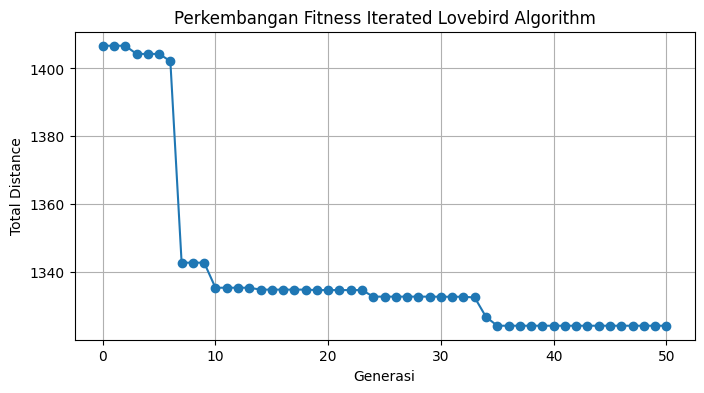

In [ ]:
# Plot history
plt.figure(figsize=(8,4))
plt.plot(hist_ail, marker='o')
plt.title("Perkembangan Fitness Iterated Lovebird Algorithm")
plt.xlabel("Generasi")
plt.ylabel("Total Distance")
plt.grid(True)
plt.show()

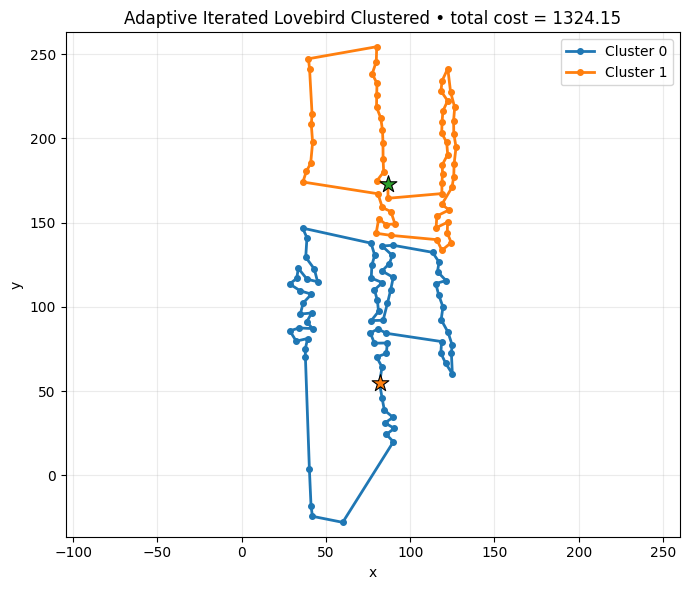

In [ ]:
# --- contoh pakai hasil lovebird ---
plot_clustered_routes_matplotlib(
    best_sol_ail,
    show_ids=False,
    title=f"Adaptive Iterated Lovebird Clustered • total cost = {best_cost_ail:.2f}"
)

# Distance Counter

In [31]:
def route_distance(route):
    if not route or len(route) < 2:
        return 0.0
    s = 0.0
    for i in range(len(route) - 1):
        s += D[idx[route[i]], idx[route[i+1]]]
    return float(s)

# Contoh pemakaian:
sample_route = [8, 84, 69, 116, 41, 108, 6, 85, 16, 60, 20, 77, 88, 76, 47, 115, 30, 55, 71, 1, 130, 101, 50, 43, 123, 67, 129, 21, 124, 26, 11, 103, 42, 4, 95, 133, 111, 63, 23, 107, 34, 72, 40, 81, 37, 96, 112, 132, 62, 93, 15, 106, 110, 54, 29, 52, 117, 10, 80, 51, 27, 59, 125, 82, 3, 90, 114, 44, 128, 58, 18, 78, 38, 53, 135, 8]
distance = route_distance(sample_route)
print("Total distance:", distance)

Total distance: 731.5083748497522


# Testing

In [128]:
def benchmark_lovebird(
    N=10,
    budget_s=None,
    # argumen problem di-pass lewat kwargs:
    **problem_kwargs
):
    """
    Jalankan iterated_lovebird dan hyper_iterated_lovebird masing2 N kali,
    simpan best_cost dan runtime, lalu balikin DataFrame + plot boxplot.
    """
    results = []

    for run_id in range(N):
        seed = run_id  # supaya replikabel

        # --- ILS biasa ---
        t0 = time.perf_counter()
        _, cost_ils, _hist_ils = iterated_lovebird(
            max_iter=30, local_gen=30,
            budget_s=budget_s,
            seed=seed,
            **problem_kwargs
        )
        t1 = time.perf_counter()
        time_ils = t1 - t0

        results.append({
            "run": run_id,
            "algo": "ILS",
            "cost": float(cost_ils),
            "time_sec": float(time_ils),
        })

        # --- Hyper ILS ---
        t0 = time.perf_counter()
        _, cost_hils, _hist_hils = hyper_iterated_lovebird(
            max_iter=30, local_gen=30, base_max_block=8,
            patience=3,
            budget_s=budget_s,
            seed=seed,
            **problem_kwargs
        )
        t1 = time.perf_counter()
        time_hils = t1 - t0

        results.append({
            "run": run_id,
            "algo": "Hyper-ILS",
            "cost": float(cost_hils),
            "time_sec": float(time_hils),
        })

    df = pd.DataFrame(results)
    return df


def plot_boxplots(df: pd.DataFrame):
    """
    Bikin dua boxplot:
    - distribusi cost
    - distribusi runtime (detik)
    """
    # --- Boxplot cost ---
    plt.figure()
    df.boxplot(column="cost", by="algo")
    plt.title("Distribusi Cost per Algoritma")
    plt.suptitle("")  # hilangkan judul default pandas
    plt.xlabel("Algoritma")
    plt.ylabel("Cost")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

    # --- Boxplot waktu ---
    plt.figure()
    df.boxplot(column="time_sec", by="algo")
    plt.title("Distribusi Runtime per Algoritma")
    plt.suptitle("")
    plt.xlabel("Algoritma")
    plt.ylabel("Waktu (detik)")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)

    plt.show()


def print_stats(df: pd.DataFrame):
    """
    Cetak ringkasan statistik cost & runtime (mean, std, median, min, max)
    mirip yang kamu tulis sebelumnya.
    """
    for algo in sorted(df["algo"].unique()):
        sub = df[df["algo"] == algo]
        cost = sub["cost"]
        t = sub["time_sec"]

        cost_mean = cost.mean()
        cost_std  = cost.std(ddof=1)
        cost_med  = cost.median()
        cost_min  = cost.min()
        cost_max  = cost.max()

        t_mean = t.mean()
        t_std  = t.std(ddof=1)
        t_med  = t.median()
        t_min  = t.min()
        t_max  = t.max()

        print(f"{algo:<9}: cost {cost_mean:.2f}±{cost_std:.2f} "
              f"(med {cost_med:.2f}) [{cost_min:.2f}, {cost_max:.2f}] | "
              f"time {t_mean:.2f}±{t_std:.2f}s "
              f"(med {t_med:.2f}) [{t_min:.2f}, {t_max:.2f}]")


Hyper-ILS: cost 1311.11±2.76 (med 1311.52) [1306.15, 1315.10] | time 15.66±3.20s (med 16.39) [11.44, 19.95]
ILS      : cost 1310.73±3.59 (med 1309.75) [1306.31, 1317.15] | time 15.59±3.55s (med 16.15) [10.99, 19.96]


<Figure size 640x480 with 0 Axes>

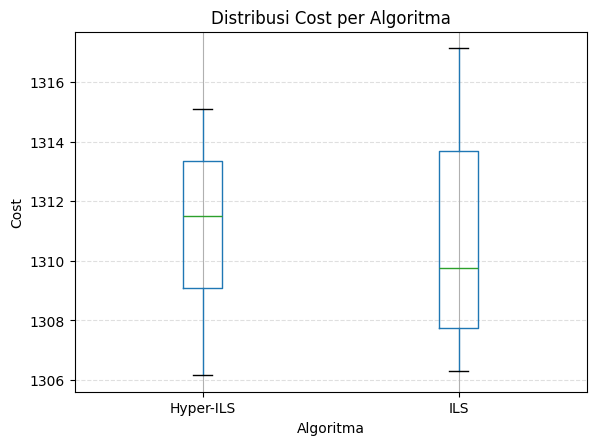

<Figure size 640x480 with 0 Axes>

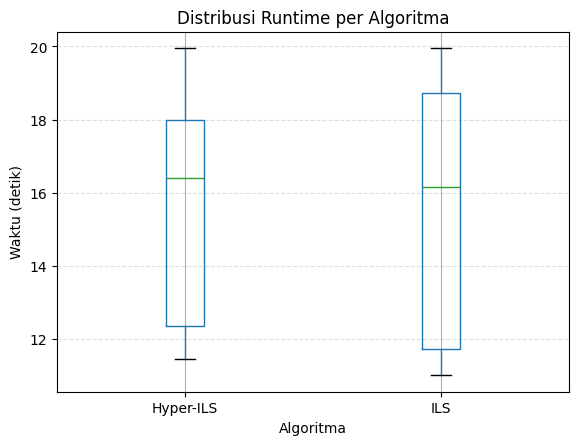

In [129]:
df = benchmark_lovebird(
    N=20,
    budget_s=20.0,      # atau None / nilai lain sesuai eksperimenmu
    labels=labels, nodes=nodes,
)

print_stats(df)     # ringkasan numerik
plot_boxplots(df)   # tampilkan boxplot